<center><br><font size=10>Final Project</font><br>
<font size=6>Daniel Shiloh</font>
<br><br>
<b>Introduction to Machine Learning – Digital Sciences for High-Tech</b>
<br><i>Spring 2025</i></center>

In [1]:
pip install optuna

Note: you may need to restart the kernel to use updated packages.


Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
import optuna
from scipy import stats as st

# for preprocessing:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

# for modeling:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# for evaluation:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score, roc_curve, auc

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Part 1: Exploration

In [3]:
#----Loading the train data-----
raw_data = pd.read_csv('train.csv')
raw_data

,ID,agency,loan_type,property_type,loan_purpose,owner_occupancy,loan_amount,preapproval,msamd,county,...,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,A,B,C,D,label
0,187616,Department of Housing and Urban Development,Conventional,One-to-four family dwelling (other than manufa...,Refinancing,Owner-occupied as a principal dwelling,160.0,Not applicable,"Lakeland, Winter Haven - FL",Polk County,...,5631.0,56.349998,52500.0,105.989998,1334.0,169.130727,NaN,2036.0,la,0
1,599925,Department of Housing and Urban Development,Conventional,One-to-four family dwelling (other than manufa...,Refinancing,Owner-occupied as a principal dwelling,235.0,NaN,"North Port, Sarasota, Bradenton - FL",Sarasota County,...,8958.0,13.610000,65500.0,89.489998,3015.0,170.521576,-3.525982,4461.0,la,0
2,139007,National Credit Union Administration,Conventional,One-to-four family dwelling (other than manufa...,Refinancing,Owner-occupied as a principal dwelling,311.0,Not applicable,"Tampa, St. Petersburg, Clearwater - FL",Hillsborough County,...,2919.0,8.050000,59800.0,191.929993,986.0,170.903815,-1.188552,1408.0,gh,1
3,437680,Department of Housing and Urban Development,FHA-insured,One-to-four family dwelling (other than manufa...,NaN,Not owner-occupied as a principal dwelling,174.0,Not applicable,"Miami, Miami Beach, Kendall - FL",Miami-Dade County,...,8960.0,96.349998,51800.0,NaN,1603.0,170.038499,12.932775,1857.0,le,0
4,445662,Consumer Financial Protection Bureau,Conventional,Manufactured housing,Home improvement,Owner-occupied as a principal dwelling,38.0,Not applicable,"West Palm Beach, Boca Raton, Delray Beach - FL",Palm Beach County,...,4055.0,14.350000,NaN,158.820007,1592.0,168.259331,16.068656,1848.0,le,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293659,574505,National Credit Union Administration,Conventional,One-to-four family dwelling (other than manufa...,Refinancing,Not owner-occupied as a principal dwelling,NaN,Not applicable,Gainesville - FL,Alachua County,...,5520.0,57.880001,65200.0,52.810001,248.0,168.061412,6.987016,1094.0,gh,0
293660,521049,Department of Housing and Urban Development,FHA-insured,One-to-four family dwelling (other than manufa...,Home purchase,Owner-occupied as a principal dwelling,307.0,Not applicable,"Fort Lauderdale, Pompano Beach, Deerfield Beac...",Broward County,...,4352.0,50.900002,64100.0,101.980003,940.0,169.279250,8.319260,1384.0,la,1
293661,547149,Consumer Financial Protection Bureau,NaN,One-to-four family dwelling (other than manufa...,NaN,Owner-occupied as a principal dwelling,6.0,Not applicable,"Orlando, Kissimmee, Sanford - FL",Osceola County,...,8568.0,63.830002,58400.0,97.110001,1872.0,169.053557,17.993804,2432.0,la,0
293662,539623,NaN,Conventional,One-to-four family dwelling (other than manufa...,Refinancing,Not owner-occupied as a principal dwelling,280.0,Not applicable,NaN,Broward County,...,NaN,80.410004,64100.0,172.770004,1419.0,NaN,13.377224,NaN,gj,0


Utility function<br>
This function helps me order some plot labels

In [4]:
def wrap_labels(ax, width, break_long_words=False):
        """
This method is to wrap the labels if their text is to long
        """
        labels = []
        for label in ax.get_xticklabels():
            text = label.get_text()
            wrapped_text = textwrap.fill(text, width=width, break_long_words=break_long_words)
            labels.append(wrapped_text)
        ax.set_xticklabels(labels, rotation=0)

## 1. Significant Features with correlation with the Label
We can see there are some features that have a certain bias towrds label = 1:
* There are some agencies that approve more than others.
* There are some loan purposes that are being approved more than others.
* There are certain msamds that get approved more than others.
* Male applicants seem more probable to get their loan approved than female.
* Applicants from a non hispanic ethnicity are more likely to get their loan approved.
* White Applicants are more likely to get their loan approved.

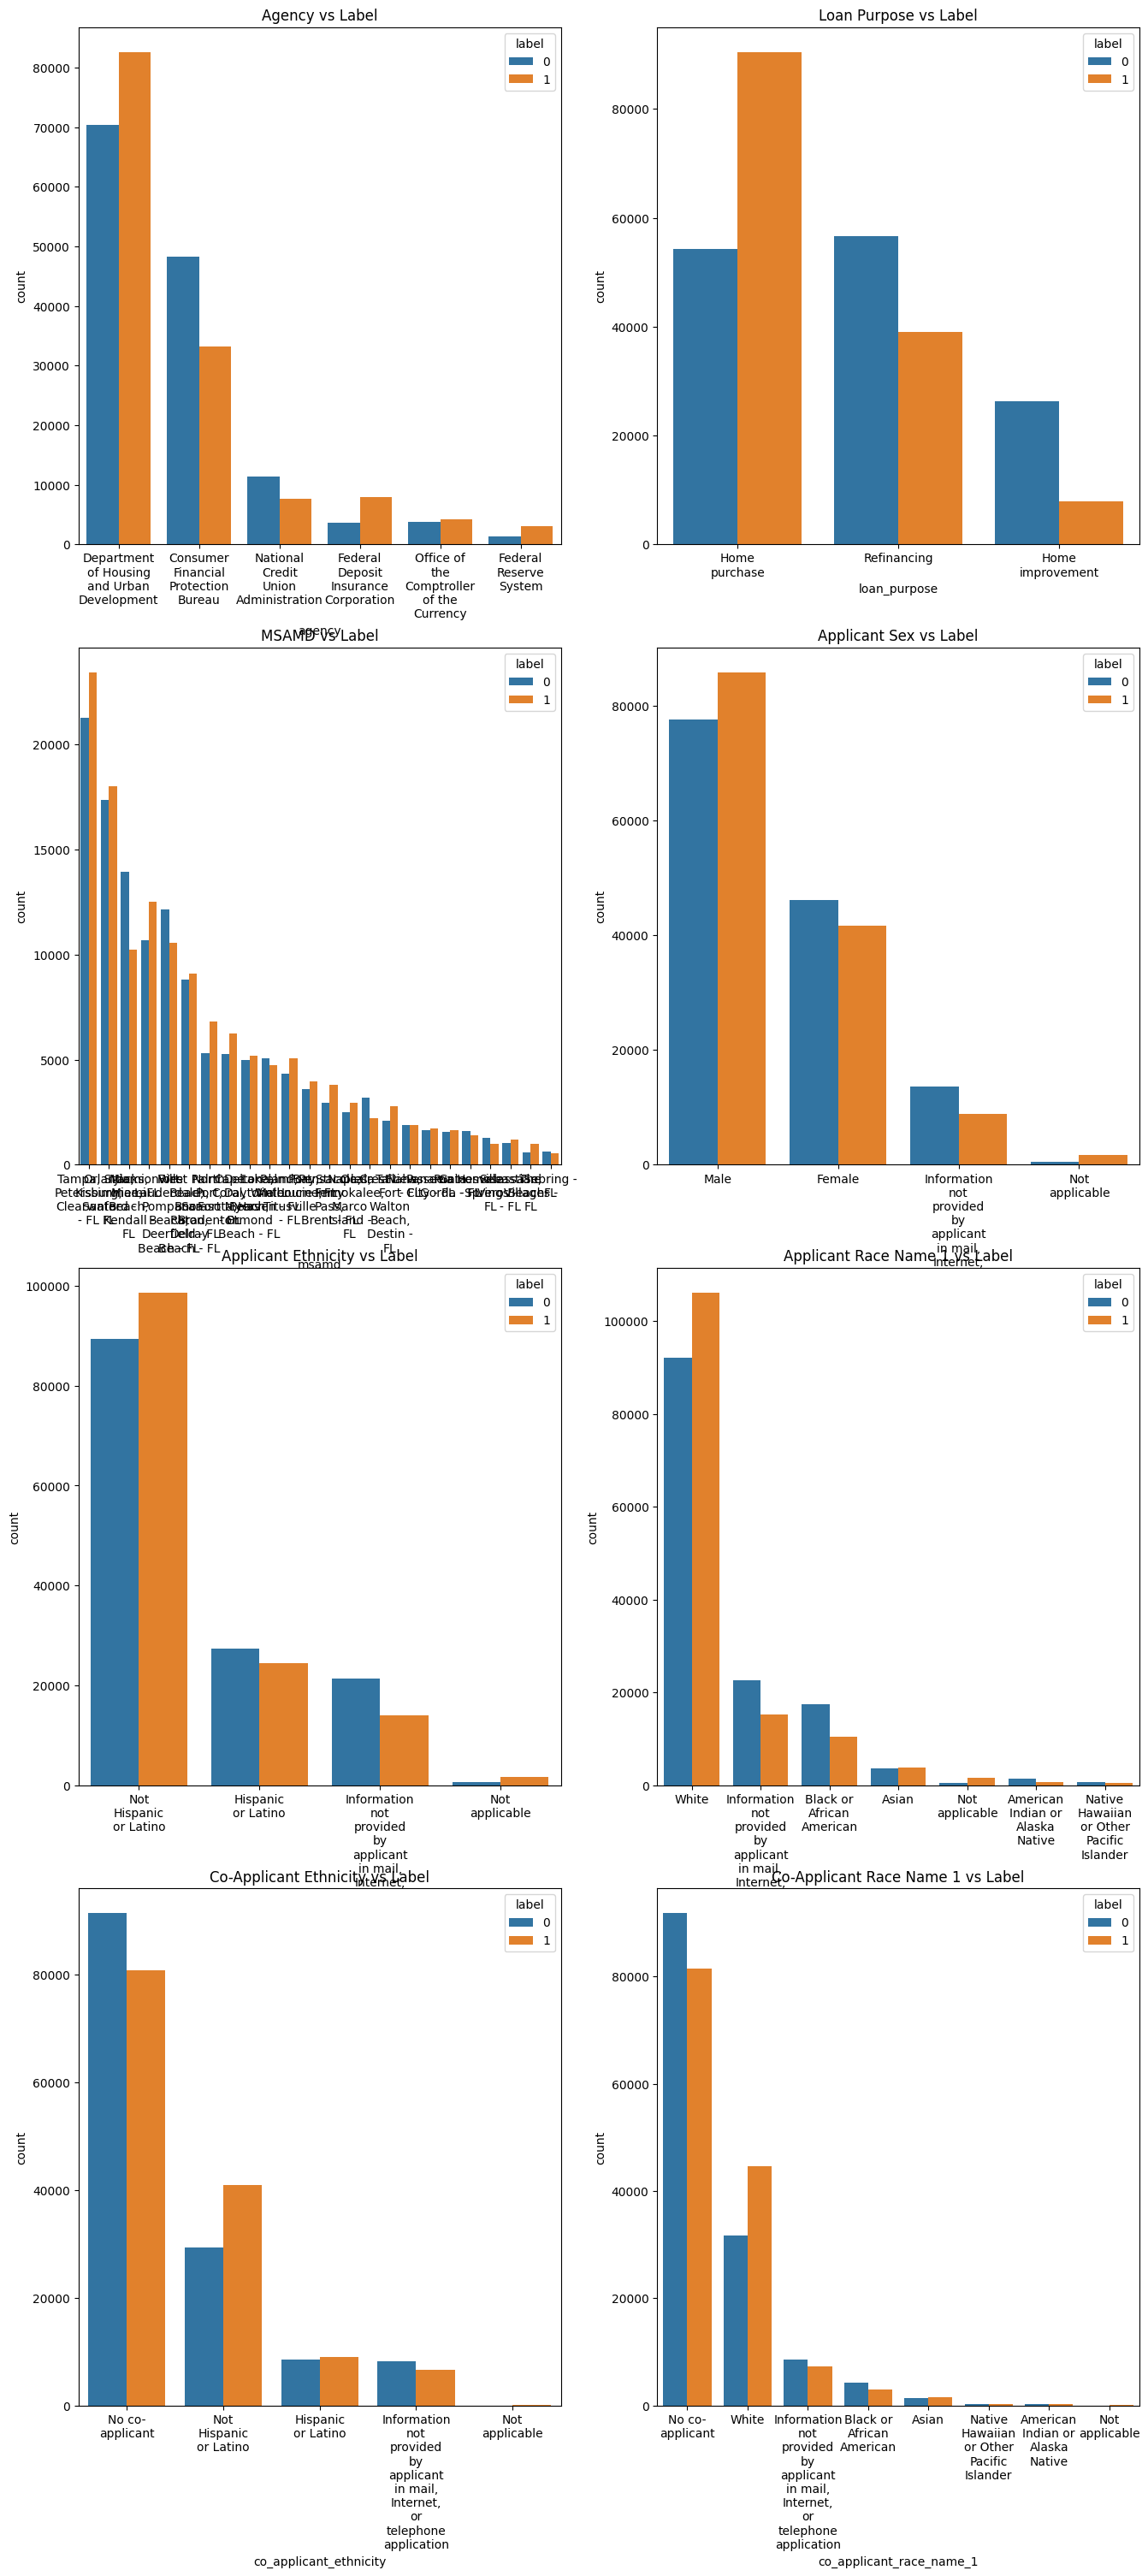

In [5]:
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
sns.countplot(ax=axes[0, 0], x='agency', hue="label", data=raw_data,order=raw_data["agency"].value_counts().index)
sns.countplot(ax=axes[0, 1], x='loan_purpose', hue="label", data=raw_data, order=raw_data["loan_purpose"].value_counts().index)
sns.countplot(ax=axes[1, 0], x='msamd', hue="label", data=raw_data, order=raw_data["msamd"].value_counts().index)
sns.countplot(ax=axes[1, 1], x='applicant_sex', hue="label", data=raw_data, order=raw_data["applicant_sex"].value_counts().index)
sns.countplot(ax=axes[2, 0], x='applicant_ethnicity', hue="label", data=raw_data, order=raw_data["applicant_ethnicity"].value_counts().index)
sns.countplot(ax=axes[2, 1], x='applicant_race_name_1', hue="label", data=raw_data, order=raw_data["applicant_race_name_1"].value_counts().index)
sns.countplot(ax=axes[3, 0], x='co_applicant_ethnicity', hue="label", data=raw_data, order=raw_data["co_applicant_ethnicity"].value_counts().index)
sns.countplot(ax=axes[3, 1], x='co_applicant_race_name_1', hue="label", data=raw_data, order=raw_data["co_applicant_race_name_1"].value_counts().index)

titles = [
    "Agency vs Label",
    "Loan Purpose vs Label",
    "MSAMD vs Label",
    "Applicant Sex vs Label",
    "Applicant Ethnicity vs Label",
    "Applicant Race Name 1 vs Label",
    "Co-Applicant Ethnicity vs Label",
    "Co-Applicant Race Name 1 vs Label"
]

for ax_row, title in zip(axes.flatten(), titles):
    ax_row.set_title(title)

for ax_row in axes:
    for ax in ax_row:
        wrap_labels(ax, 10)

plt.subplots_adjust(top=1.5)

## 2. Correlation between applicants and co-applicants features
In this correlation table we can see the correlation between the applicant and the co-applicant ethinicity.<br>
We can see:
* Most people don't have a co-applicant
* Most of those who do have a co-applicant, are the same ethnicity as their co-applicant 

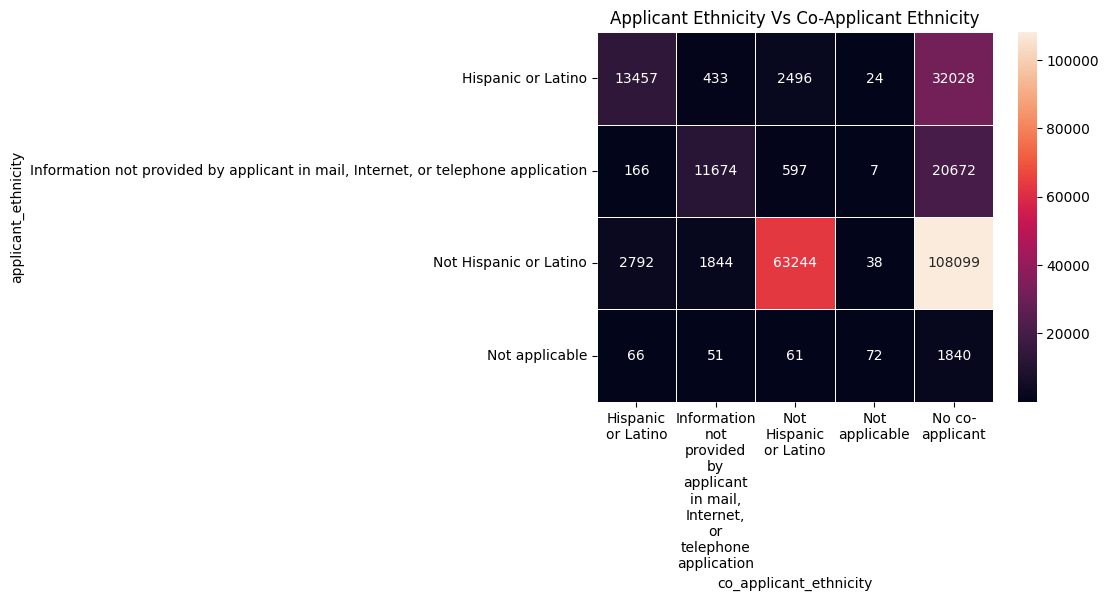

In [6]:
correlation_table = pd.crosstab(raw_data['applicant_ethnicity'],raw_data['co_applicant_ethnicity'])
parallel = correlation_table.index.intersection(correlation_table.columns)
non_parallel = correlation_table.columns.difference(correlation_table.index)
correlation_table = correlation_table.loc[:, list(parallel) + list(non_parallel)]
correlation_table = correlation_table.reindex(list(parallel) + list(correlation_table.index.difference(parallel)))
plot = sns.heatmap(correlation_table, annot=True, linewidths=.5,fmt=".0f")
wrap_labels(plot,10)
plt.title("Applicant Ethnicity Vs Co-Applicant Ethnicity")
plt.show()

In this correlation table we can see the correlation between the applicant and the co-applicant sex.<br>
We can see:
* Most people don't have a co-applicant. (No surprise)
* Most of those who do have a co-applicant, are the opposite sex from their co-applicant's sex 


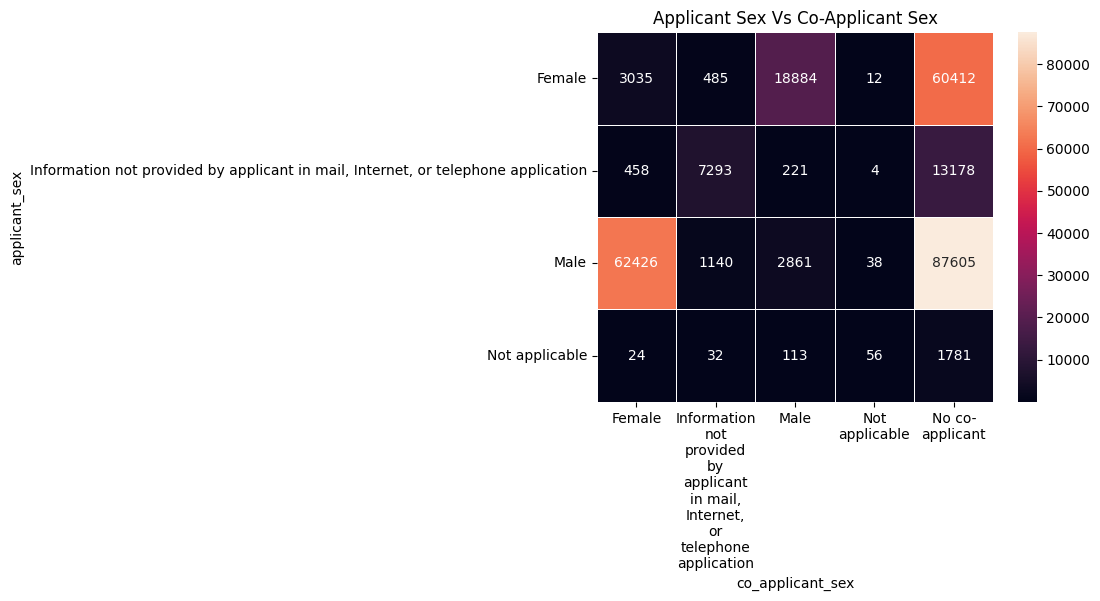

In [7]:
correlation_table = pd.crosstab(raw_data['applicant_sex'],raw_data['co_applicant_sex'])
parallel = correlation_table.index.intersection(correlation_table.columns)
non_parallel = correlation_table.columns.difference(correlation_table.index)
correlation_table = correlation_table.loc[:, list(parallel) + list(non_parallel)]
correlation_table = correlation_table.reindex(list(parallel) + list(correlation_table.index.difference(parallel)))
plot = sns.heatmap(correlation_table, annot=True, linewidths=.5,fmt=".0f")
wrap_labels(plot,10)
plt.title("Applicant Sex Vs Co-Applicant Sex")
plt.show()

In this correlation table we can see the correlation between the applicant and the co-applicant race.<br>
We can see:
* Most people don't have a co-applicant. (No surprise)
* In most cases, people are from the same race as their co-applicant.


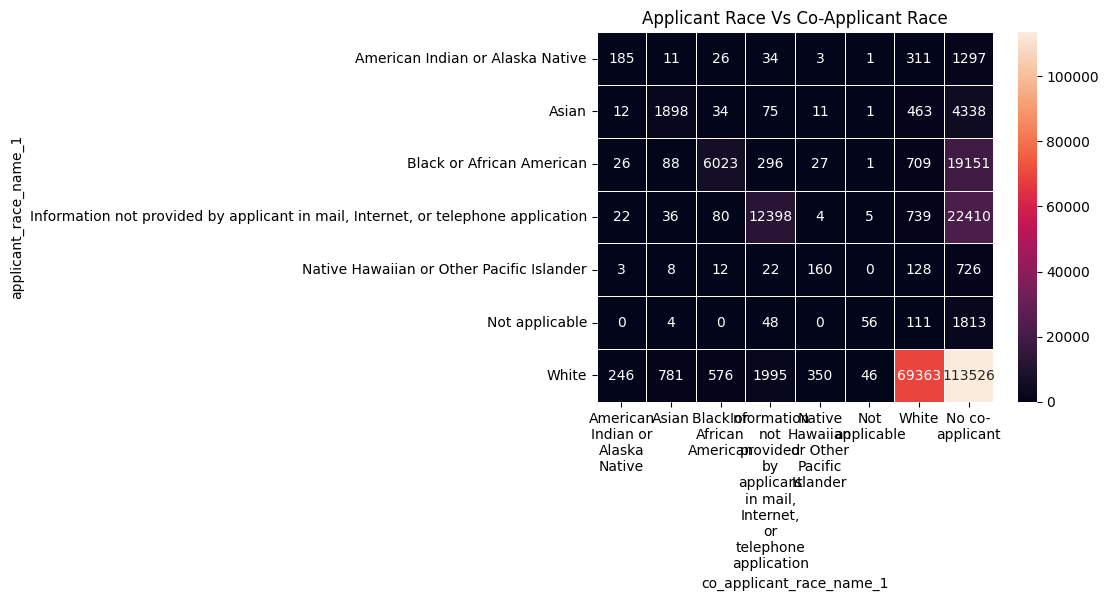

In [8]:
correlation_table = pd.crosstab(raw_data['applicant_race_name_1'],raw_data['co_applicant_race_name_1'])
parallel = correlation_table.index.intersection(correlation_table.columns)
non_parallel = correlation_table.columns.difference(correlation_table.index)
correlation_table = correlation_table.loc[:, list(parallel) + list(non_parallel)]
correlation_table = correlation_table.reindex(list(parallel) + list(correlation_table.index.difference(parallel)))
plot = sns.heatmap(correlation_table, annot=True, linewidths=.5,fmt=".0f")
wrap_labels(plot,10)
plt.title("Applicant Race Vs Co-Applicant Race")
plt.show()

<u><font size=5>Conclusion</font></u><br>
We will use all of this information when filling the missing values in these columns

## 3. The Numeric Features

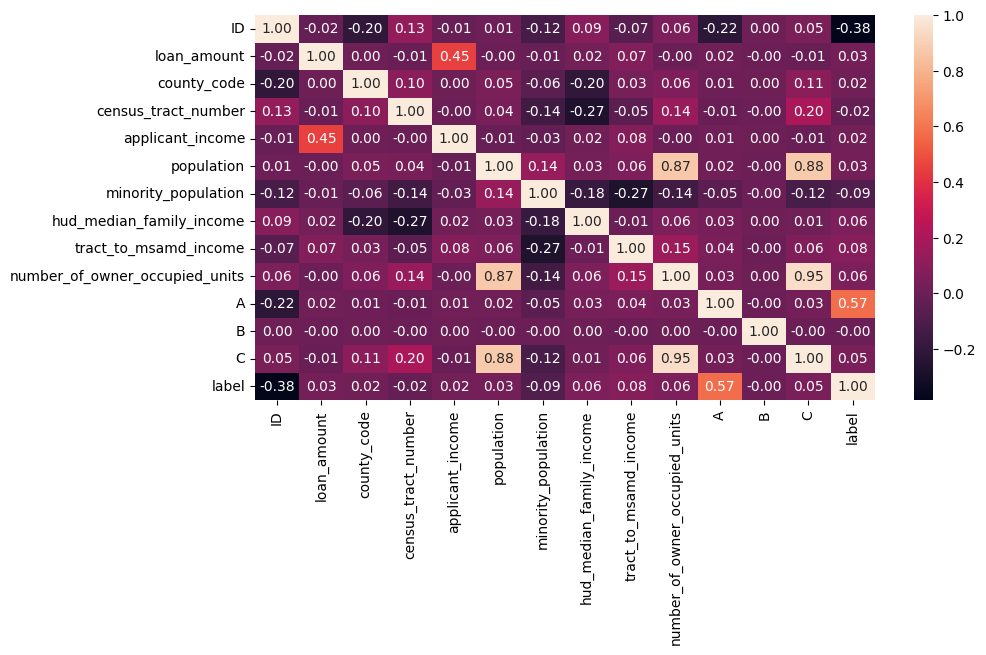

In [9]:
plt.figure(figsize=(10,5))
sns.heatmap(raw_data.corr(),xticklabels=raw_data.corr().columns,yticklabels=raw_data.corr().columns,annot=True,fmt=".2f")
plt.show()

We can see some correlations between features:
* The population and the number of owner occupied units.
* The population and the feature C.
* The number of owner occupied units and the feature C.
* The applicant income and the amount of the loan. 
* The feture A and the label

We will use some of this information for filling the missing values in these columns

### The ID Surprise

While examining the features I came across the histogram of the ID columnn:

Text(0.5, 1.0, 'ID histogram')

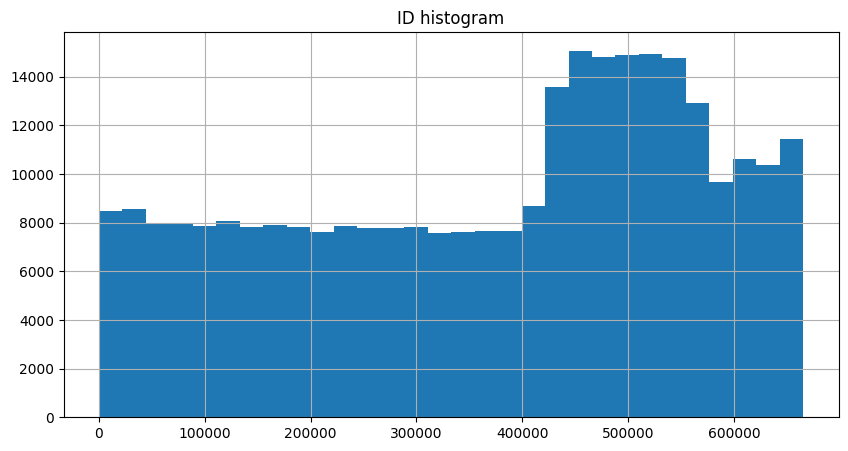

In [10]:
raw_data["ID"].hist(bins=30, figsize=(10, 5))
plt.title("ID histogram")

We can see a very clear increase in the amount of application with an ID of more than 400000.<br>
I checked the distribuation of the application with label 1 and label 0, for applications with an ID below and above 400000:

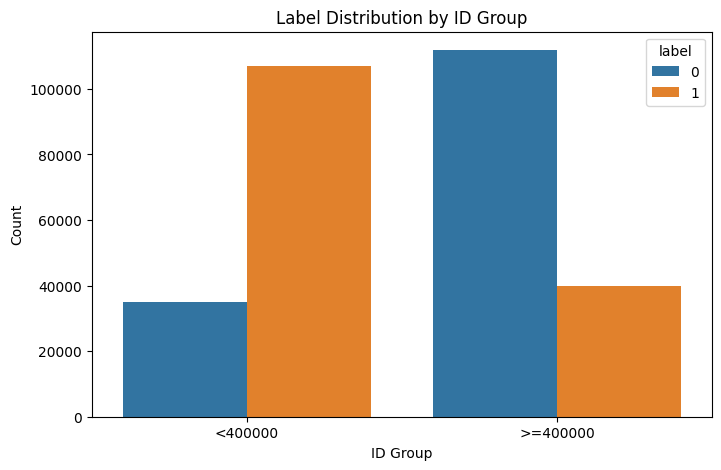

In [11]:
raw_data['ID_group'] = raw_data['ID'].apply(lambda x: '<400000' if x < 400000 else '>=400000')

plt.figure(figsize=(8, 5))
sns.countplot(x='ID_group', hue='label', data=raw_data)
plt.title('Label Distribution by ID Group')
plt.xlabel('ID Group')
plt.ylabel('Count')
plt.show()
raw_data.drop(columns=['ID_group'], inplace=True)

Even though we would think that the ID column is arbitrary and shouldn't affect the predicting model, it seems that applications with an ID bigger than 400000 are less likely to be approved.<br>
<u><font size=5>Conclusion</font></u><br>
We will choose to keep the ID column for our modeling even though it seems counter-intuitve.

### Loan Amount & Applicant Income

These features have a lot of outliers we'll need to remove before modeling:

Number of outliers for loan_amount: 10991
Number of outliers for applicant_income: 19548


<Axes: title={'center': 'Applicant Income'}>

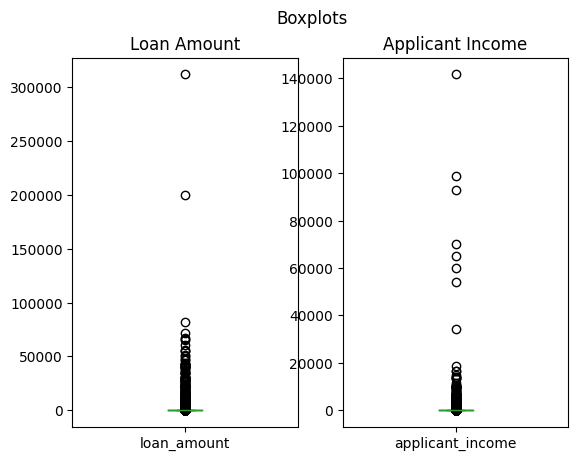

In [12]:
for col in ["loan_amount","applicant_income"]:
    stats = raw_data[col].describe()
    Q1 = stats["25%"]
    Q3 = stats["75%"]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = raw_data[col][(raw_data[col] < lower_bound) | (raw_data[col] > upper_bound)]
    print(f"Number of outliers for {col}: {len(outliers)}")

plt.suptitle("Boxplots")
plt.subplot(1,2,1)
plt.title("Loan Amount")
plt.figure
raw_data["loan_amount"].plot.box()
plt.subplot(1,2,2)
plt.title("Applicant Income")
raw_data["applicant_income"].plot.box()

This graph shows the distribution of approved and rejected loan applications by the applicant's income up to the third quntile:

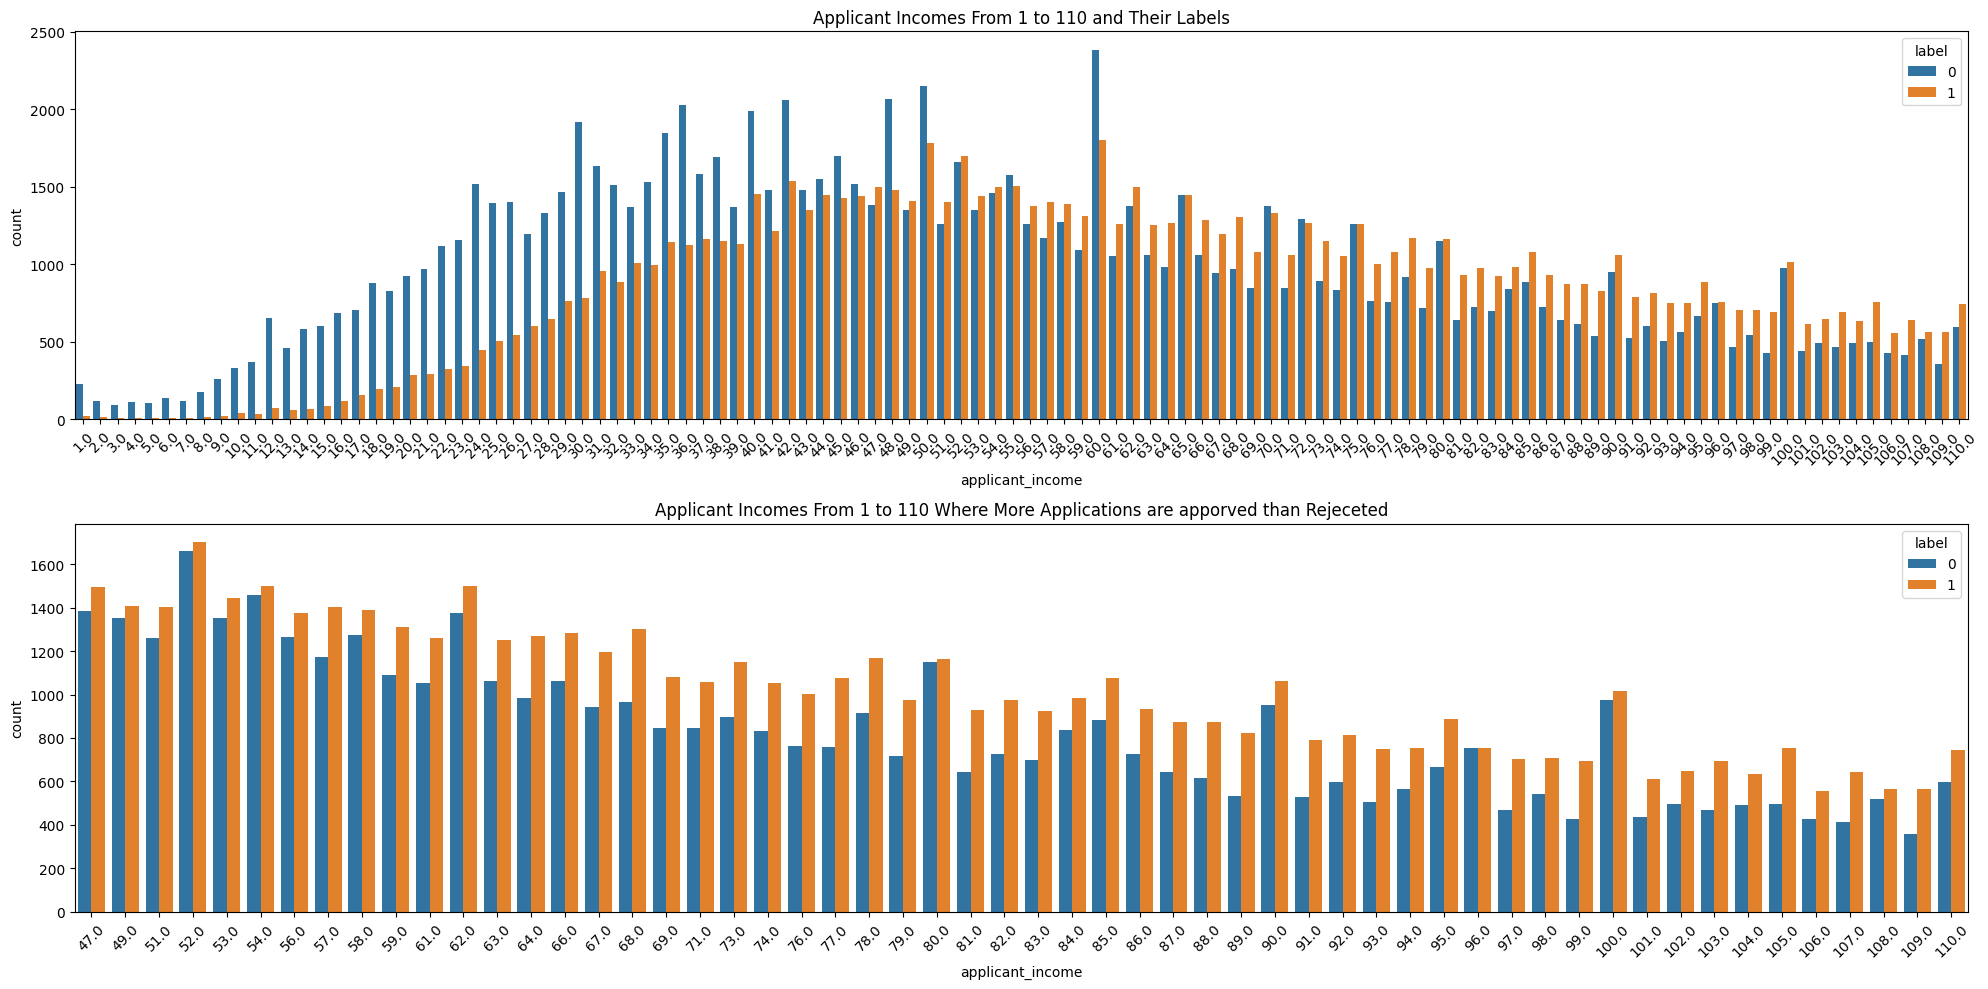

In [13]:
lower_bound = 1
upper_bound = 110
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
counterplot = sns.countplot(ax=axes[0],x='applicant_income', data=raw_data[(raw_data["applicant_income"]<=upper_bound) & (raw_data["applicant_income"]>=lower_bound)], hue="label")
axes[0].set_title("Applicant Incomes From " + str(lower_bound) + " to " + str(upper_bound) + " and Their Labels")
axes[0].tick_params(axis='x', rotation=45)

grouped = raw_data[(raw_data["applicant_income"]<=upper_bound) & (raw_data["applicant_income"]>=lower_bound)].groupby(['applicant_income', 'label']).size().unstack(fill_value=0)
filtered_incomes = grouped[grouped[1] > grouped[0]].index
filtered_data = raw_data[raw_data['applicant_income'].isin(filtered_incomes)]
sns.countplot(ax=axes[1],x='applicant_income', hue='label', data=filtered_data)
axes[1].set_title("Applicant Incomes From " + str(lower_bound) + " to " + str(upper_bound) + " Where More Applications are apporved than Rejeceted")
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


obeservation:<br>
The threshold where more applications were approved than rejected is 47,000$.

This scattermap shows the relation between the applicant income, loan amount and the label.

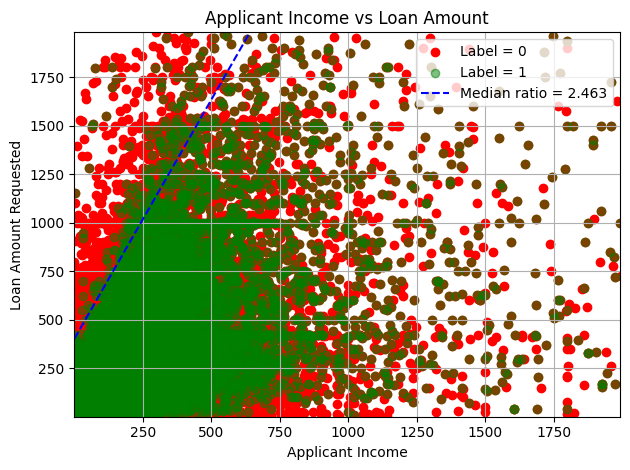

In [14]:
mask = (raw_data["applicant_income"]<2000) & (raw_data["loan_amount"]<2000)
plt.scatter(raw_data[mask]["applicant_income"],raw_data[mask]["loan_amount"],color='red', label='Label = 0')

approved = raw_data[mask & raw_data["label"] == 1]
sct = plt.scatter(approved["applicant_income"], approved["loan_amount"],color='green',alpha=0.5, label = 'Label = 1')
slopes = (approved["loan_amount"]/approved["applicant_income"]).median()
plt.axline((0,400),slope=slopes,color='blue',linestyle='--',label=f"Median ratio = {slopes:.3f}")

plt.xlabel("Applicant Income")
plt.ylabel("Loan Amount Requested")
plt.xlim((approved["applicant_income"].min(),approved["applicant_income"].max()))
plt.ylim((approved["loan_amount"].min(),approved["loan_amount"].max()))
plt.legend()
plt.title("Applicant Income vs Loan Amount")
plt.grid(True)
plt.tight_layout()
plt.show()

We can see the line where the ratio between the applicant income and their request are being approved more than other ratios. It almost follows the median ratio of 2.463

This bar-graph presents the percentage of the income by the requested loan and their label.<br>
The X-axis presents the percentages (the equation:
$ \frac{application\_income}{loan\_amount} * 100 $) and the Y-axis presents the sum of application. <br>The colors divide the labels

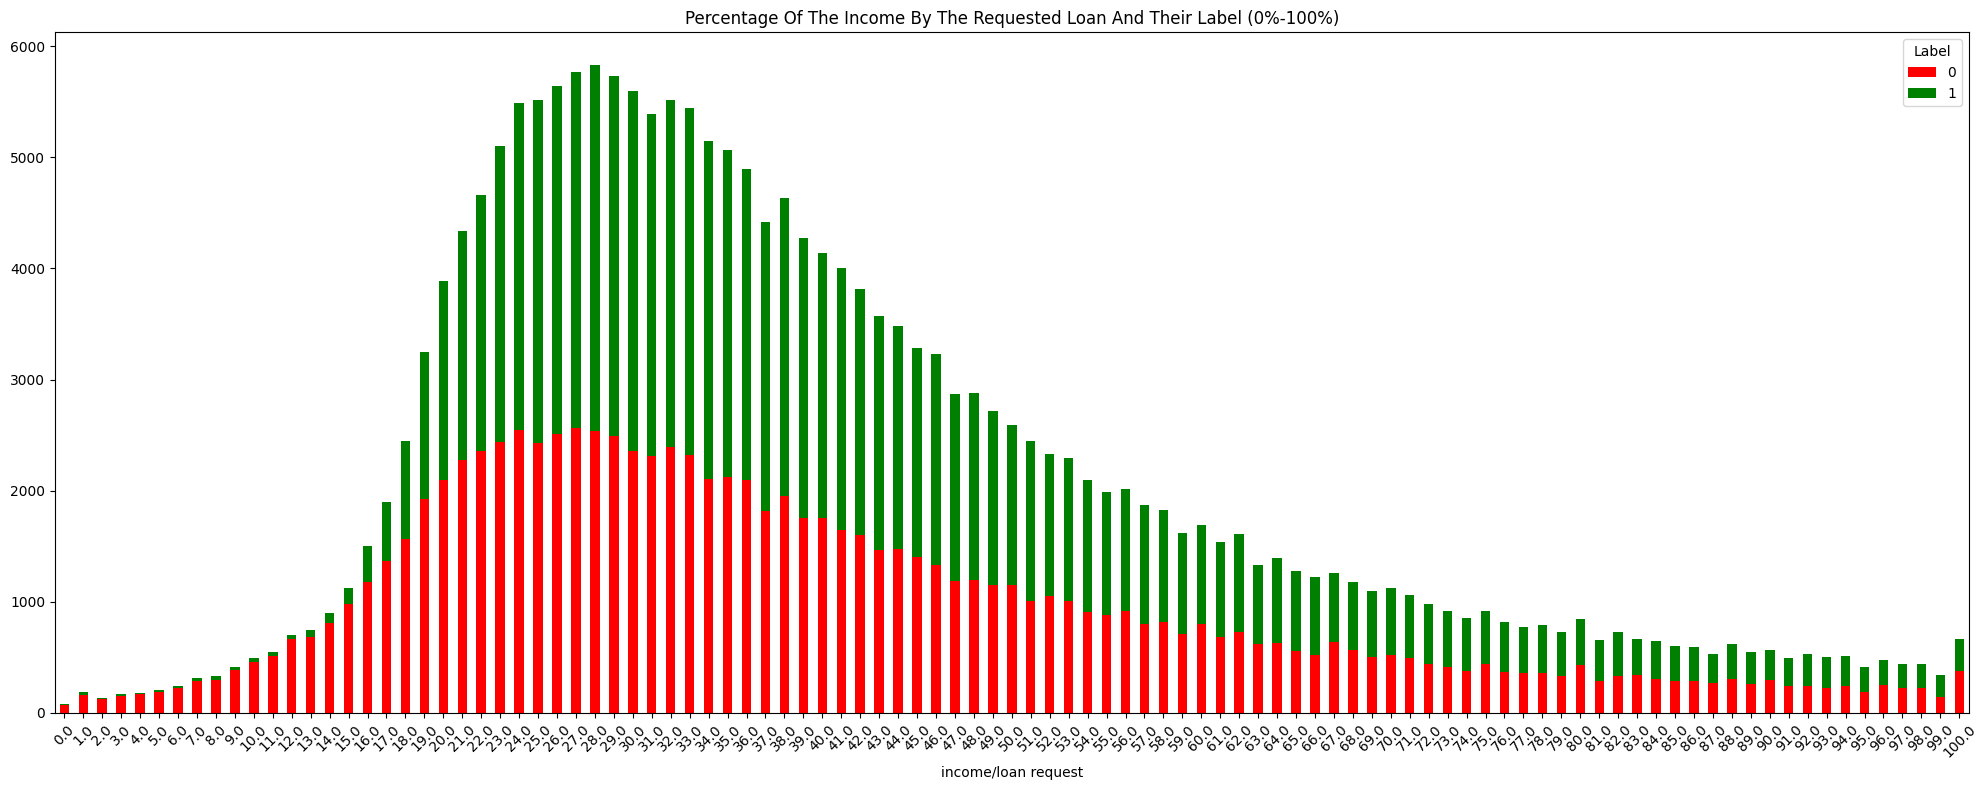

In [15]:
precentages = round((raw_data[mask]["applicant_income"]*100)/raw_data[mask]["loan_amount"],0)
df = pd.DataFrame()
df["precentages"] = precentages
df["label"] = raw_data["label"]

grouped = df[df['precentages']<=100].groupby(['precentages', 'label']).size().unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True, color=['red', 'green'],figsize=(20,8))
plt.xticks(rotation = 45)
plt.title("Percentage Of The Income By The Requested Loan And Their Label (0%-100%)")
plt.tight_layout()
plt.xlabel("income/loan request")
plt.legend(title='Label')
plt.show()


We got a Gaussian.<br>
Most of the people request a loan which is around 4 times their income

### Significant Features with correlation with the label

This bar-graph presents the distribution of Minority Population by label

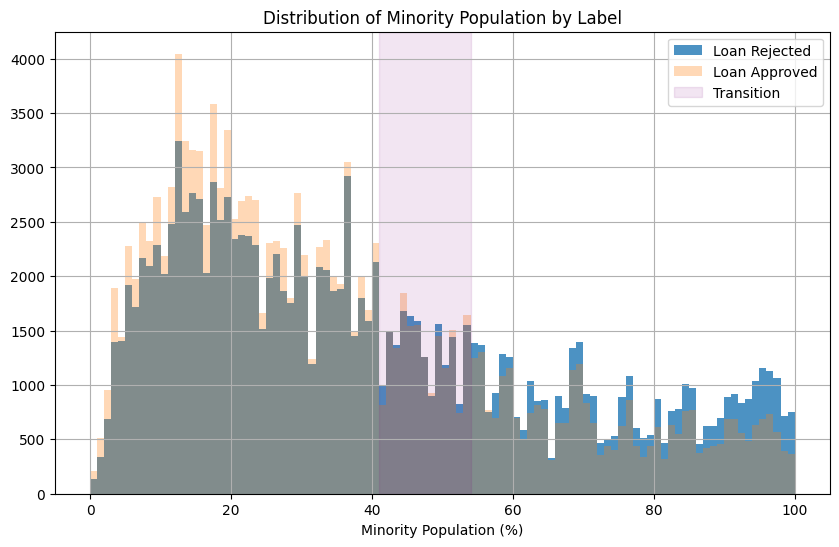

In [16]:
plt.figure(figsize=(10, 6))

plt.hist(raw_data[raw_data["label"] == 0]["minority_population"], bins=100,alpha=0.8, label="Loan Rejected")
plt.hist(raw_data[raw_data["label"] == 1]["minority_population"], bins=100,alpha=0.3 , label="Loan Approved")

plt.title('Distribution of Minority Population by Label')
plt.xlabel('Minority Population (%)')
plt.axvspan(41, 54, color='purple', alpha=0.1, label='Transition')
plt.legend()
plt.grid(True)
plt.show()

Observation:<br>
There is a threshold around 50% minority population, we can see a shift in the ratio between approved and rejected loans

We can see a similar pattern in hud_median_family_income:

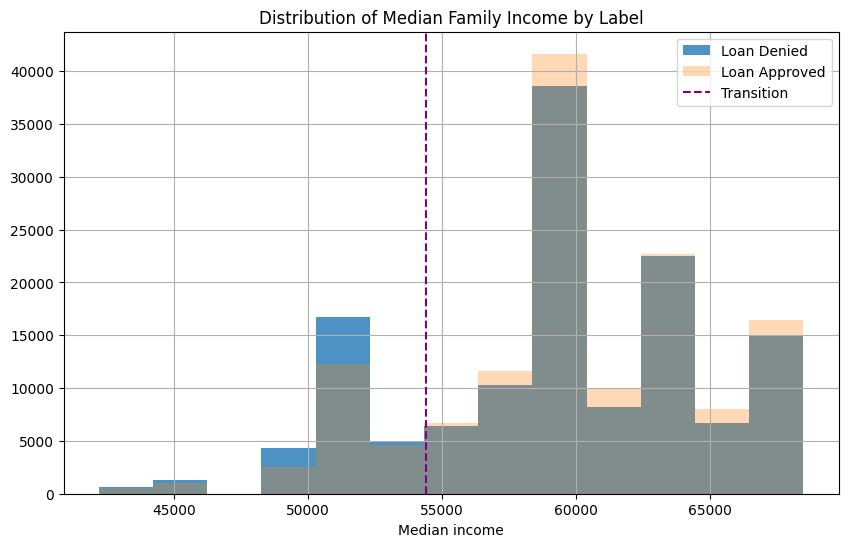

In [17]:
plt.figure(figsize=(10, 6))

plt.hist(raw_data[raw_data["label"] == 0]["hud_median_family_income"], bins=13,alpha=0.8, label="Loan Denied")
plt.hist(raw_data[raw_data["label"] == 1]["hud_median_family_income"], bins=13,alpha=0.3 , label="Loan Approved")

plt.title('Distribution of Median Family Income by Label')
plt.xlabel('Median income')
plt.axvline(54400, color='purple', ls="--", label='Transition')
plt.legend()
plt.grid(True)
plt.show()

### The unknown features

Unfortunalty I couldn't quite understand what these columns represent but I can see how they are distributed:

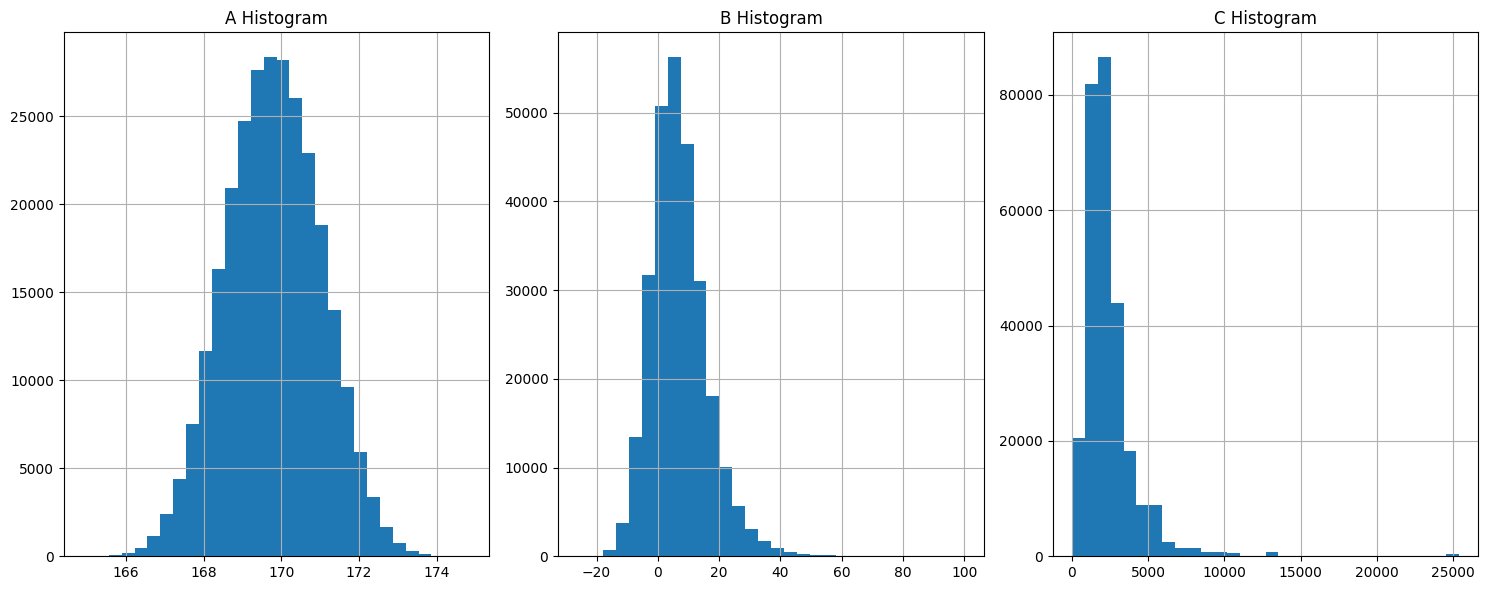

In [18]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
raw_data["A"].hist(bins=30)
plt.title("A Histogram")
plt.subplot(1,3,2)
raw_data["B"].hist(bins=30)
plt.title("B Histogram")
plt.subplot(1,3,3)
raw_data["C"].hist(bins=30)
plt.title("C Histogram")
plt.tight_layout()
plt.show()

Feature A and feature B seem to distribute normally and C doesn't.<br>
However, we saw there is a high correlation between C and the feature number_of_owner_occupied_units:

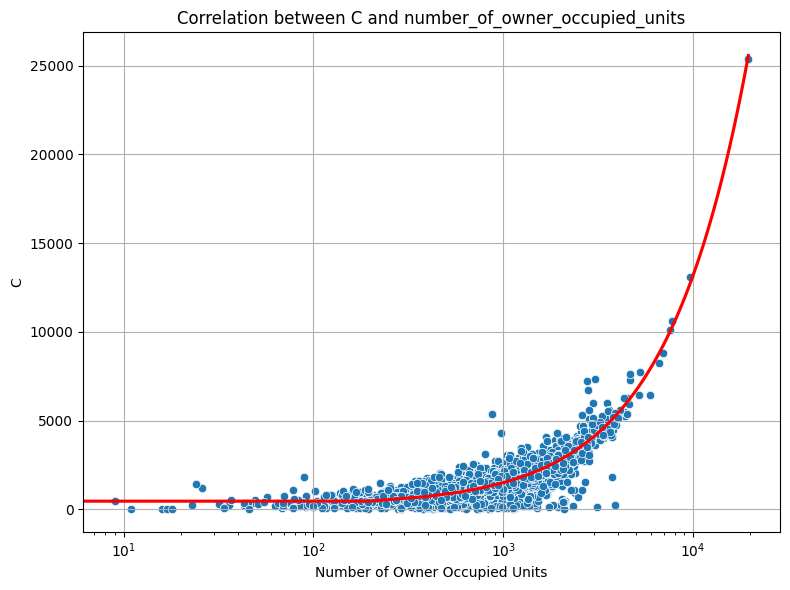

In [19]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="number_of_owner_occupied_units", y="C", data=raw_data)
x_vals = raw_data["number_of_owner_occupied_units"]
y_vals = raw_data["C"]
sns.regplot(x=x_vals, y=y_vals, scatter=False, color='red')
plt.title('Correlation between C and number_of_owner_occupied_units')
plt.xlabel('Number of Owner Occupied Units')
plt.ylabel('C')
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()

We will try to use this correlation when filling their missing values.<br>
We also know there is a correlation between feature A and the label. We'll keep an eye out for occurances of this feature in our dimensionality reduction and modeling

# Part 2: Preprocessing

In [20]:
fixed_data = raw_data.copy()
fixed_data


,ID,agency,loan_type,property_type,loan_purpose,owner_occupancy,loan_amount,preapproval,msamd,county,...,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,A,B,C,D,label
0,187616,Department of Housing and Urban Development,Conventional,One-to-four family dwelling (other than manufa...,Refinancing,Owner-occupied as a principal dwelling,160.0,Not applicable,"Lakeland, Winter Haven - FL",Polk County,...,5631.0,56.349998,52500.0,105.989998,1334.0,169.130727,NaN,2036.0,la,0
1,599925,Department of Housing and Urban Development,Conventional,One-to-four family dwelling (other than manufa...,Refinancing,Owner-occupied as a principal dwelling,235.0,NaN,"North Port, Sarasota, Bradenton - FL",Sarasota County,...,8958.0,13.610000,65500.0,89.489998,3015.0,170.521576,-3.525982,4461.0,la,0
2,139007,National Credit Union Administration,Conventional,One-to-four family dwelling (other than manufa...,Refinancing,Owner-occupied as a principal dwelling,311.0,Not applicable,"Tampa, St. Petersburg, Clearwater - FL",Hillsborough County,...,2919.0,8.050000,59800.0,191.929993,986.0,170.903815,-1.188552,1408.0,gh,1
3,437680,Department of Housing and Urban Development,FHA-insured,One-to-four family dwelling (other than manufa...,NaN,Not owner-occupied as a principal dwelling,174.0,Not applicable,"Miami, Miami Beach, Kendall - FL",Miami-Dade County,...,8960.0,96.349998,51800.0,NaN,1603.0,170.038499,12.932775,1857.0,le,0
4,445662,Consumer Financial Protection Bureau,Conventional,Manufactured housing,Home improvement,Owner-occupied as a principal dwelling,38.0,Not applicable,"West Palm Beach, Boca Raton, Delray Beach - FL",Palm Beach County,...,4055.0,14.350000,NaN,158.820007,1592.0,168.259331,16.068656,1848.0,le,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293659,574505,National Credit Union Administration,Conventional,One-to-four family dwelling (other than manufa...,Refinancing,Not owner-occupied as a principal dwelling,NaN,Not applicable,Gainesville - FL,Alachua County,...,5520.0,57.880001,65200.0,52.810001,248.0,168.061412,6.987016,1094.0,gh,0
293660,521049,Department of Housing and Urban Development,FHA-insured,One-to-four family dwelling (other than manufa...,Home purchase,Owner-occupied as a principal dwelling,307.0,Not applicable,"Fort Lauderdale, Pompano Beach, Deerfield Beac...",Broward County,...,4352.0,50.900002,64100.0,101.980003,940.0,169.279250,8.319260,1384.0,la,1
293661,547149,Consumer Financial Protection Bureau,NaN,One-to-four family dwelling (other than manufa...,NaN,Owner-occupied as a principal dwelling,6.0,Not applicable,"Orlando, Kissimmee, Sanford - FL",Osceola County,...,8568.0,63.830002,58400.0,97.110001,1872.0,169.053557,17.993804,2432.0,la,0
293662,539623,NaN,Conventional,One-to-four family dwelling (other than manufa...,Refinancing,Not owner-occupied as a principal dwelling,280.0,Not applicable,NaN,Broward County,...,NaN,80.410004,64100.0,172.770004,1419.0,NaN,13.377224,NaN,gj,0


## Missing Values

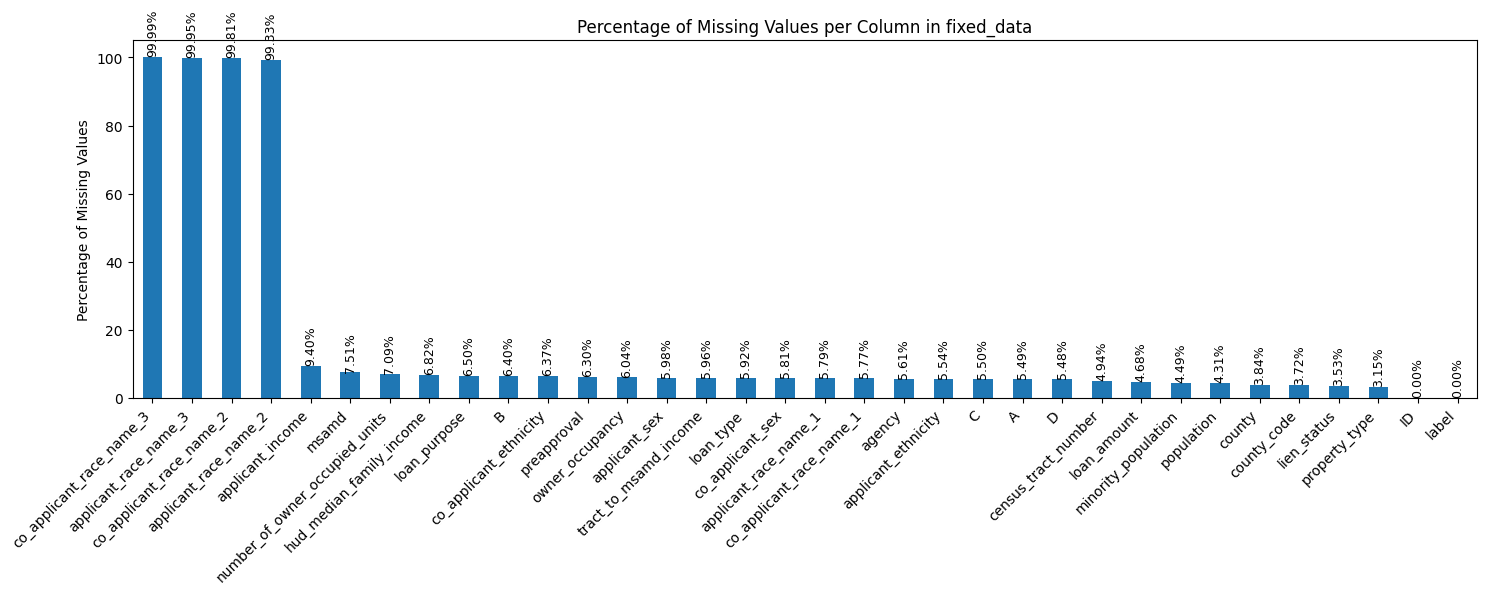

In [ ]:
# The percentages of missing values in the features
missing_percent = fixed_data.isnull().mean() * 100
ax = missing_percent.sort_values(ascending=False).plot(kind='bar', figsize=(15,6))
for i, v in enumerate(missing_percent.sort_values(ascending=False)):
    ax.text(i, v + 0.2, f"{v:.2f}%", ha='center', va='bottom', fontsize=9, rotation=90)
ax.set_ylabel('Percentage of Missing Values')
ax.set_title('Percentage of Missing Values per Column in fixed_data')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

There are uniformative columns that we would want to remove. These columns would be the columns that don't have enough values in order to be filled. We don't want our model to learn from overwhelmingly partial data. This will reduce the dimensions of the probelm naturally.<br>
We will drop the features:<br>
* applicant_race_name_2
* applicant_race_name_3
* co_applicant_race_name_2
* co_applicant_race_name_3
<br>

We have seen in the exploration part that the ID does have a corrolation to the given label so we'll keep it in the data. 

In [22]:
fixed_data = fixed_data.drop(['applicant_race_name_2','applicant_race_name_3','co_applicant_race_name_2','co_applicant_race_name_3'], axis=1)

Now let's take a look at the columns we would like to fill:

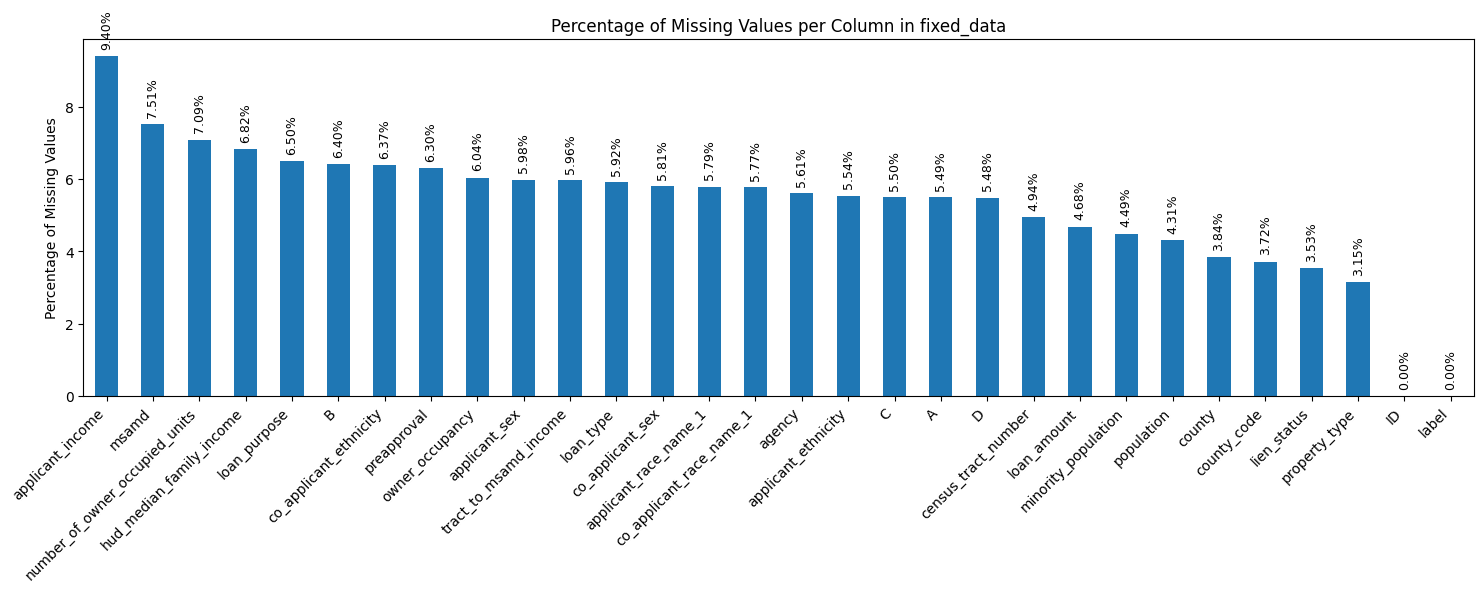

In [23]:
missing_percent = fixed_data.isnull().mean() * 100
ax = missing_percent.sort_values(ascending=False).plot(kind='bar', figsize=(15,6))
for i, v in enumerate(missing_percent.sort_values(ascending=False)):
    ax.text(i, v + 0.2, f"{v:.2f}%", ha='center', va='bottom', fontsize=9, rotation=90)
ax.set_ylabel('Percentage of Missing Values')
ax.set_title('Percentage of Missing Values per Column in fixed_data')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The columns A and B are gaussians.
* Column A doesn't have a lot of outliers and is centrelized so I decided to fill the missing values with the mean.
* Column B does have outliers but looks like a normal distribution so I decided to fill the missing values with the median.
* Column D is categorical and was filled with the most frequent value.

In [24]:
num_cols = ['A', 'B']
A_mean_imputer = SimpleImputer(strategy='mean')
B_median_imputer = SimpleImputer(strategy='median')
cat_mode_imputer = SimpleImputer(strategy='most_frequent')
fixed_data['A'] = A_mean_imputer.fit_transform(fixed_data[['A']])
fixed_data['B'] = B_median_imputer.fit_transform(fixed_data[['B']])
fixed_data['D'] = cat_mode_imputer.fit_transform(fixed_data[['D']])

For some columns we see there is a correlation between their values: 
* County and county code represent the same thing
* A census tract should have a fixed population size and minority population percentage across the data
* MSAMD and census tract numbers
* I saw there is an almost 1-to-1 correlation between the column C and the column "number_of_owner_occupied_units"

Therfore, I want to fill the missing values in these columns using their related columns and vice versa.<br>
Doing so, I'm assuming the columns are injective functions of each other.<br>
In the following code I check how many values in these columns have ambiguous values making the assumption false:h to ignore their error.

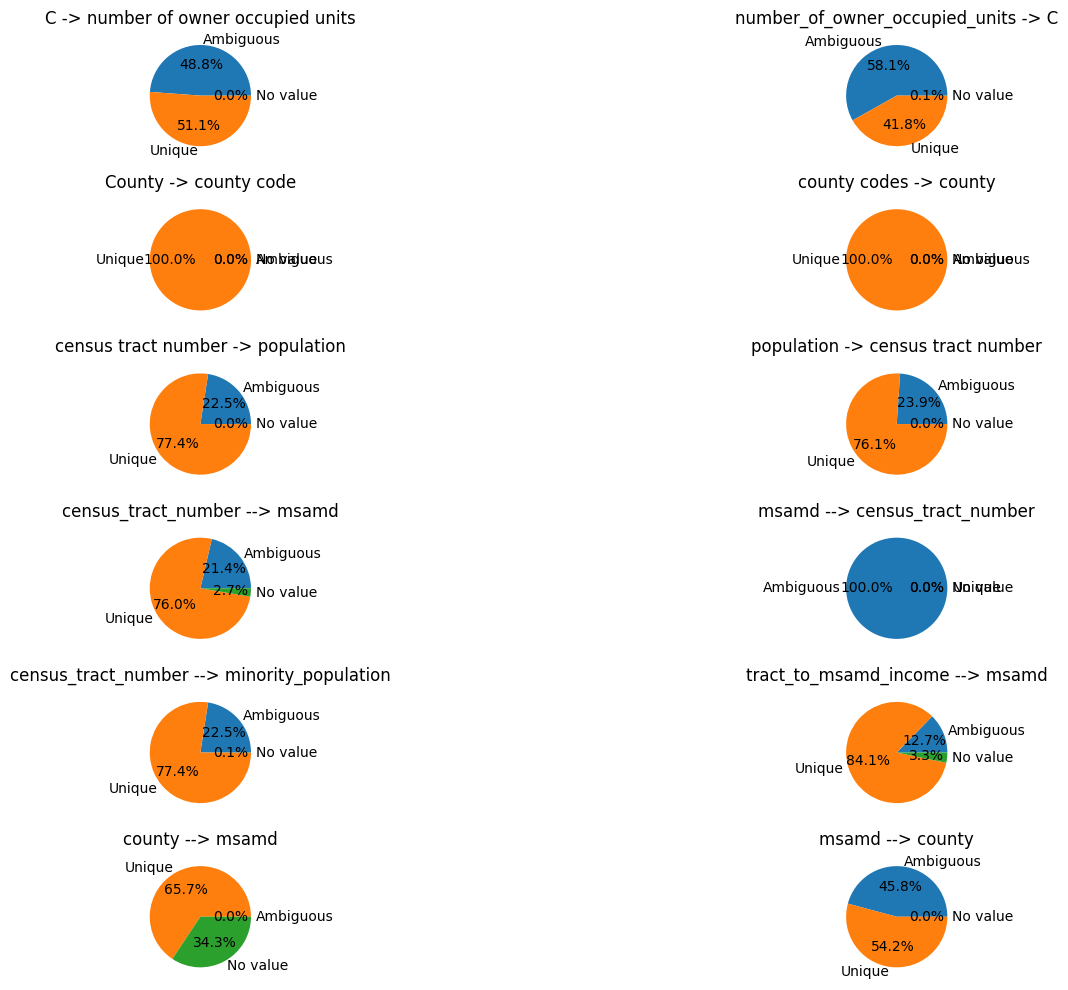

In [25]:
C_to_nooou = raw_data.groupby('C')['number_of_owner_occupied_units'].nunique()
nooou_to_C = raw_data.groupby('number_of_owner_occupied_units')['C'].nunique()
county_to_code = raw_data.groupby('county')['county_code'].nunique()
code_to_county = raw_data.groupby('county_code')['county'].nunique()
census_to_population = raw_data.groupby('census_tract_number')['population'].nunique()
population_to_census = raw_data.groupby('population')['census_tract_number'].nunique()
msamd_to_ttmi = raw_data.groupby('msamd')['tract_to_msamd_income'].nunique()
ttmi_to_msamd = raw_data.groupby('tract_to_msamd_income')['msamd'].nunique()
census_to_minority = raw_data.groupby('census_tract_number')['minority_population'].nunique()
census_to_msamd = raw_data.groupby('census_tract_number')['msamd'].nunique()
msamd_to_census = raw_data.groupby('msamd')['census_tract_number'].nunique()
county_to_msamd = raw_data.groupby('county')['msamd'].nunique()
msamd_to_county = raw_data.groupby('msamd')['county'].nunique()

groupings = [
    (C_to_nooou, 'C -> number of owner occupied units'),
    (nooou_to_C, 'number_of_owner_occupied_units -> C'),
    (county_to_code, 'County -> county code'),
    (code_to_county, 'county codes -> county'),
    (census_to_population, 'census tract number -> population'),
    (population_to_census, 'population -> census tract number'),
    (census_to_msamd, 'census_tract_number --> msamd'),
    (msamd_to_census, 'msamd --> census_tract_number'),
    (census_to_minority, 'census_tract_number --> minority_population'),
    (ttmi_to_msamd, 'tract_to_msamd_income --> msamd'),
    (county_to_msamd, 'county --> msamd'),
    (msamd_to_county, 'msamd --> county')
]

plt.figure(figsize=(18, 10))
for i, (grp, title) in enumerate(groupings, 1):
    sizes = [len(grp[grp > 1]), len(grp[grp == 1]), len(grp[grp == 0])]
    labels = ['Ambiguous', 'Unique', 'No value']
    plt.subplot(6, 2, i)
    plt.pie(sizes, labels=labels, autopct='%1.1f%%')
    plt.title(title)
plt.tight_layout()
plt.show()


These pie charts show that it is possible to predict the value of the column when given another column in some features. <br>
For all the data that has more than 75% unique, I'll assume there is a 1-to-1 relation in order to fill the missing values.
Therfore I fill:
* County with county code and vice versa
* Census_tract_number with population and vice versa
* msamd with tract_to_msamd_income
* minority_population with census_tract_number

So after this process I'll have county, county_code, census_tract_number, population, msamd and minority_population filled completely

In [26]:
def fill_col1_and_col2(target_df, col1, col2, train_df=None, viceversa=False, unique_fill=False):
    """
    Fills missing values in two columns based on the mapping from a training DataFrame.
    If there are more than one unique value from col2 in col1 and the values are numerical, We use the median value of col2 for the filling.
    If there are more than one unique value from col2 in col1 and the values aren't numerical we use the first value found.
    If `viceversa` is True, it also fills missing values in the opposite direction, in the same method as mentioned above.
    If `unique_fill` is True, it fills the remaining missing values in the first column with its own most frequent value.
    If `unique_fill` is False, it fills the remaining missing values in the first column based on the most frequent value in the second column.
    """
    # Check if the training DataFrame is provided; if not, use the target DataFrame
    if train_df is None:
        train_df = target_df
    
    # Build mapping dictionaries from the training DataFrame
    col1_to_col2 = train_df.dropna(subset=[col1, col2]).groupby(col1)[col2].apply(lambda x: x.unique().tolist()).to_dict()
    try:
        col1_to_col2 = {k: np.median(v) for k, v in col1_to_col2.items()}
    except:
        try:
            col1_to_col2 = {k: v[0] for k, v in col1_to_col2.items()}
        except:
            col1_to_col2 = {k: v for k, v in col1_to_col2.items()}

    if viceversa:
        col2_to_col1 = train_df.dropna(subset=[col1, col2]).groupby(col2)[col1].apply(lambda x: x.unique().tolist()).to_dict()
        try:
            col2_to_col1 = {k: np.median(v) for k, v in col2_to_col1.items()}
        except:
            try:
                col2_to_col1 = {k: v[0] for k, v in col1_to_col2.items()}
            except:
                col2_to_col1 = {k: v for k, v in col1_to_col2.items()}

    
    # Fill missing values in the target DataFrame
    missing_col2 = target_df[col2].isnull() & target_df[col1].notnull()
    target_df.loc[missing_col2, col2] = target_df.loc[missing_col2, col1].map(col1_to_col2)
    if viceversa:
        missing_col1 = target_df[col1].isnull() & target_df[col2].notnull()
        target_df.loc[missing_col1, col1] = target_df.loc[missing_col1, col2].map(col2_to_col1)
    
    # Fill remaining missing values
    if viceversa:
        # If `unique_fill` is True, it fills the remaining missing values in each column with its own most frequent value.
        if unique_fill:
            most_freq_col2 = train_df[col2].mode()[0]
            target_df[col2].fillna(most_freq_col2, inplace=True)
            most_freq_col1 = train_df[col1].mode()[0]
            target_df[col1].fillna(most_freq_col1, inplace=True)
        # If `unique_fill` is False, it fills the remaining missing values in the second column based on the most frequent value in the first column.
        else:
            most_freq_col1 = train_df[col1].mode()[0]
            target_df[col1].fillna(most_freq_col1, inplace=True)
            target_df[col2].fillna(col1_to_col2[most_freq_col1], inplace=True)
    else:
        most_freq_col2 = train_df[col2].mode()[0]
        target_df[col2].fillna(most_freq_col2, inplace=True)
    
    return target_df


In [27]:
fixed_data = fill_col1_and_col2(fixed_data, 'county','county_code',viceversa=True, unique_fill=False)
fixed_data = fill_col1_and_col2(fixed_data, 'census_tract_number','population',viceversa=True, unique_fill=False)
fixed_data = fill_col1_and_col2(fixed_data, 'tract_to_msamd_income','msamd', viceversa=False)
fixed_data = fill_col1_and_col2(fixed_data, 'census_tract_number','minority_population', viceversa=False)

I Fill loan amount with the median of each loan purpose

In [28]:
# Calculate the median for each loan purpose
refin_median = fixed_data[fixed_data['loan_purpose'] == "refinencing"]['loan_amount'].median()
home_pur_median = fixed_data[fixed_data['loan_purpose'] == "Home purchase"]['loan_amount'].median()
home_imp_median = fixed_data[fixed_data['loan_purpose'] == "Home improvement"]['loan_amount'].median()
general_loan_amount_median = fixed_data['loan_amount'].median()

# Fill missing values in 'loan_amount' based on 'loan_purpose'
fixed_data.loc[fixed_data['loan_purpose'] == "Home purchase", 'loan_amount'] = fixed_data[fixed_data['loan_purpose'] == "Home purchase"]['loan_amount'].fillna(home_pur_median)
fixed_data.loc[fixed_data['loan_purpose'] == "refinencing", 'loan_amount'] = fixed_data[fixed_data['loan_purpose'] == "refinencing"]['loan_amount'].fillna(refin_median)
fixed_data.loc[fixed_data['loan_purpose'] == "Home improvement", 'loan_amount'] = fixed_data[fixed_data['loan_purpose'] == "Home improvement"]['loan_amount'].fillna(home_imp_median)
fixed_data['loan_amount'] = fixed_data['loan_amount'].fillna(general_loan_amount_median)

These columns don't have "Not applicable" as an option so I try to predict the missing values using the most frequent value they got in corrolation to another column that should be in corrolation: <br>
- The loan type and loan purpose should corrolate with the amount of loan being requested.
- The cencus tract number and minority population should corrolate with the population column.
- The agency, property type, hud_median_family should corrolate with the census tract number.

In [29]:
def fill_null_with_mode(target_df, cols, mode_col,train_df=None):
    """
    Fill Null values in columns with the mode of a specific column.
    """
    if train_df is None:
        train_df = target_df
        
    for col in cols:
        na_mask = target_df[col].isna()
        for idx in target_df[na_mask].index:
            value = target_df.loc[idx, mode_col]
            mode_value = train_df.loc[
                (train_df[mode_col] == value) & (~train_df[col].isna()), col
                ].mode()
            if not mode_value.empty:
                target_df.at[idx, col] = mode_value[0]
        # If there are still NaN values, fill them with the most common value in the column
        if target_df[col].isna().any():
            most_common_value = train_df[col].mode()[0]
            target_df[col].fillna(most_common_value, inplace=True)
    
    return target_df

fixed_data = fill_null_with_mode(fixed_data, ['loan_type', 'loan_purpose'],'loan_amount')
fixed_data = fill_null_with_mode(fixed_data, ['agency','property_type','hud_median_family_income','tract_to_msamd_income', 'number_of_owner_occupied_units'],'census_tract_number')
fixed_data = fill_null_with_mode(fixed_data, ["C"], "number_of_owner_occupied_units")

These columns have a Not applicable option so we'll fill the missing information with it.

In [ ]:
# Fill missing values in preapproval, owner_occupancy and lien_status with Not applicable
cat_cols = ['preapproval','owner_occupancy','lien_status']
fixed_data[cat_cols] = fixed_data[cat_cols].fillna('Not applicable')

# Fill missing applicant values with Not provided
applicant_cols = ['applicant_ethnicity','applicant_race_name_1','applicant_sex']
fixed_data[applicant_cols] = fixed_data[applicant_cols].fillna('Not provided')

These columns regard the co-applicant and were filled according to the data in them and in the applicant columns.
* If one of the co-applicant features has the value "No co-applicant" then all the other co-applicant features are getting filled with this value too.
* For all the other cases: co-applicant ethnicity and co-applicant race should be filled with the applicant's values for these columns
* co-applicant sex is filled with the opposite of the applicant's sex.
* If there isn't applicant sex value in order to fill the co-applicant's, fill the remaining co-applicant sex values with "Not provided"

In [31]:
# Missing co applicant values
nca_str = "No co-applicant"
mask = ((fixed_data['co_applicant_ethnicity'] == nca_str) | (fixed_data['co_applicant_race_name_1'] == nca_str) | (fixed_data['co_applicant_sex'] == nca_str))
for col in ['co_applicant_ethnicity','co_applicant_race_name_1','co_applicant_sex']:
    fixed_data.loc[mask, col] = fixed_data.loc[mask, col].fillna('No co-applicant')
fixed_data['co_applicant_ethnicity'] = fixed_data['co_applicant_ethnicity'].fillna(fixed_data['applicant_ethnicity'])
fixed_data['co_applicant_race_name_1'] = fixed_data['co_applicant_race_name_1'].fillna(fixed_data['applicant_race_name_1'])
fixed_data[fixed_data['applicant_sex']=='Male']["co_applicant_sex"] = fixed_data[fixed_data['applicant_sex']=='Male']["co_applicant_sex"].fillna('Female')
fixed_data[fixed_data['applicant_sex']=='Female']["co_applicant_sex"] = fixed_data[fixed_data['applicant_sex']=='Female']["co_applicant_sex"].fillna('Male')
fixed_data["co_applicant_sex"] = fixed_data["co_applicant_sex"].fillna('Not provided')

In order to assess the missing applicant income values, i'll use the medians of the existing applicant incomes grouped by ethnicity and sex.<br>
Each null value will be filled with the average between the median of the income for their ethnicity group and their sex

In [32]:
median_income_by_ethnicity = fixed_data.groupby("applicant_ethnicity")["applicant_income"].median()
median_income_by_sex = fixed_data.groupby("applicant_sex")["applicant_income"].median()
na_mask = fixed_data['applicant_income'].isna()
for idx in fixed_data[na_mask].index:
    sex = fixed_data.loc[idx, 'applicant_sex']
    ethnicity = fixed_data.loc[idx, 'applicant_ethnicity']
    fixed_data.at[idx, 'applicant_income'] = (median_income_by_sex[sex] + median_income_by_ethnicity[ethnicity]) / 2

## Merging Unknown values in the categorical features

There are some catagorical features that we saw in the exploration part that have overlapping values (for example: Not provided and Not applicable).<br>
We will merge them into a single value in order to get less dimensions when modeling.

In [33]:
def merge_values(df, cols):
    for col in cols:
        mask1 = df[col] == "Information not provided by applicant in mail, Internet, or telephone application"
        mask2 = df[col] == "Not applicable"
        df.loc[mask1,col] = "Not provided"
        df.loc[mask2,col] = "Not provided"
    return df

cat_feat_to_fix = ["applicant_ethnicity","applicant_race_name_1","co_applicant_ethnicity","co_applicant_race_name_1","applicant_sex","co_applicant_sex"]
fixed_data = merge_values(fixed_data,cat_feat_to_fix)


We'll keep the full data without the next steps in a seperate df in order to prepare the test data in the future.

In [34]:
full_data = fixed_data.copy()

## Outliers

There are many outliers in different numerical features. We will trim them so they have only the top 99% of the values.

In [35]:
def remove_outliers(target_df, cols):
    for col in cols:
        q99 = target_df[col].quantile(0.99)
        target_df[col] = target_df[col].clip(upper=q99)
    return target_df

fixed_data = remove_outliers(fixed_data, ['loan_amount', 'applicant_income', 'tract_to_msamd_income'])

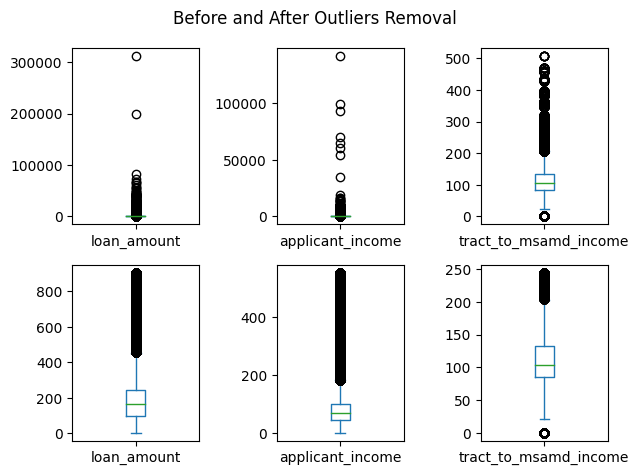

In [36]:
plt.subplot(2,3,1)
raw_data["loan_amount"].plot.box()
plt.subplot(2,3,2)
raw_data["applicant_income"].plot.box()
plt.subplot(2,3,3)
raw_data["tract_to_msamd_income"].plot.box()
plt.subplot(2,3,4)
fixed_data["loan_amount"].plot.box()
plt.subplot(2,3,5)
fixed_data["applicant_income"].plot.box()
plt.subplot(2,3,6)
fixed_data["tract_to_msamd_income"].plot.box()
plt.suptitle("Before and After Outliers Removal")
plt.tight_layout()
plt.show()

## Create new features

Instead of using the county, MSAMD and census tract as features, we'll replace them with the percentage of approved loans in each of them.

In [37]:

# calculate the approval rate for each county
county_approval_rate = fixed_data.groupby('county')['label'].mean()
county_approval_rate = county_approval_rate.clip(lower=1e-6,upper= 1 - 1e-6)
fixed_data['county_approval_rate'] = fixed_data['county'].map(county_approval_rate)
# calculate the approval rate for each msamd
msamd_approval_rate = fixed_data.groupby('msamd')['label'].mean()
msamd_approval_rate = msamd_approval_rate.clip(lower=1e-6,upper= 1 - 1e-6)
fixed_data['msamd_approval_rate'] = fixed_data['msamd'].map(msamd_approval_rate)
# calculate the approval rate for each census tract
census_tract_approval_rate = fixed_data.groupby('census_tract_number')['label'].mean()
census_tract_approval_rate = census_tract_approval_rate.clip(lower=1e-6,upper= 1 - 1e-6)
fixed_data['census_tract_approval_rate'] = fixed_data['census_tract_number'].map(census_tract_approval_rate)

#--- the results here will be used to map the approval rates in the test set as well

# drop unnecessary columns
fixed_data = fixed_data.drop(["county",'county_code','msamd','census_tract_number'],axis=1)


## Encode categorical features

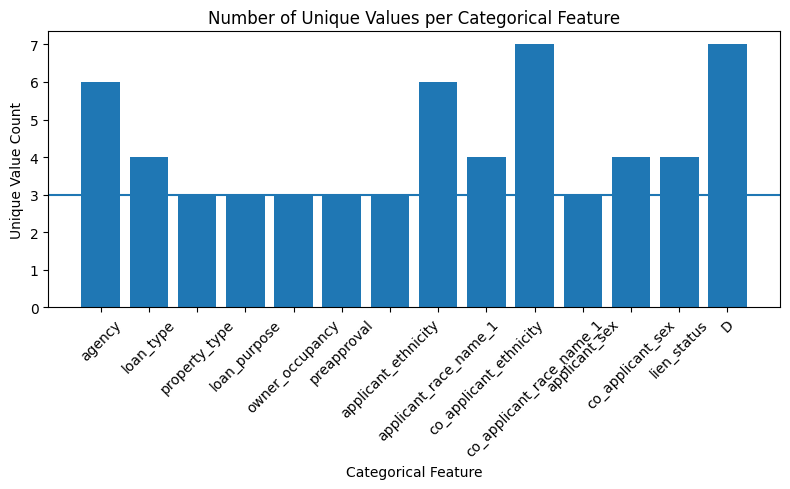

In [38]:
categorical_cols = fixed_data.select_dtypes(include=['object', 'category']).columns
unique_counts = {col: fixed_data[col].nunique() for col in categorical_cols}
plt.figure(figsize=(8, 5))
graph = plt.bar(unique_counts.keys(), unique_counts.values())
plt.title("Number of Unique Values per Categorical Feature")
plt.xlabel("Categorical Feature")
plt.ylabel("Unique Value Count")
plt.xticks(rotation = 45)
plt.axhline(3)
plt.tight_layout()
plt.show()

We'll use different methods for encoding the categorical features depanding on their meaning.

In [ ]:
categorical_cols = fixed_data.select_dtypes(include=['object', 'category']).columns
# --- features with more than 3 unique categories for OrdinalEncoder()
cat_for_OE = categorical_cols[fixed_data[categorical_cols].nunique()>3]
# --- features with 3 or less unique categories for pd.get_dummies()
cat_for_dummy = categorical_cols[fixed_data[categorical_cols].nunique()<=3]

enc = OrdinalEncoder()
fixed_data[cat_for_OE] = enc.fit_transform(fixed_data[cat_for_OE])
dummies = pd.get_dummies(fixed_data[cat_for_dummy], prefix=cat_for_dummy, drop_first=True)
fixed_data = pd.concat([fixed_data.drop(columns=cat_for_dummy), dummies], axis=1)

## Split features and label

In [40]:
full_X = fixed_data.drop('label', axis=1)
y = fixed_data['label']
print(full_X.shape, y.shape)

(293664, 34) (293664,)


In [41]:
full_X

,ID,agency,loan_type,loan_amount,applicant_race_name_1,co_applicant_ethnicity,co_applicant_race_name_1,co_applicant_sex,applicant_income,lien_status,...,loan_purpose_Home purchase,loan_purpose_Refinancing,owner_occupancy_Not owner-occupied as a principal dwelling,owner_occupancy_Owner-occupied as a principal dwelling,preapproval_Preapproval was not requested,preapproval_Preapproval was requested,applicant_ethnicity_Not Hispanic or Latino,applicant_ethnicity_Not provided,applicant_sex_Male,applicant_sex_Not provided
0,187616,1.0,0.0,160.0,4.0,1.0,4.0,2.0,87.0,2.0,...,0,1,0,1,0,0,0,1,0,1
1,599925,1.0,0.0,235.0,4.0,3.0,5.0,3.0,119.0,2.0,...,0,1,0,1,0,0,0,1,0,1
2,139007,4.0,0.0,311.0,4.0,1.0,4.0,2.0,131.0,2.0,...,0,1,0,1,0,0,0,1,0,1
3,437680,1.0,1.0,174.0,4.0,1.0,4.0,2.0,54.0,2.0,...,1,0,1,0,0,0,0,0,0,0
4,445662,0.0,0.0,38.0,5.0,1.0,4.0,2.0,131.0,1.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293659,574505,4.0,0.0,166.0,5.0,1.0,4.0,2.0,116.0,2.0,...,0,1,1,0,0,0,1,0,0,0
293660,521049,1.0,1.0,307.0,5.0,0.0,6.0,0.0,79.0,2.0,...,1,0,0,1,0,0,0,0,1,0
293661,547149,0.0,0.0,6.0,5.0,1.0,4.0,2.0,25.0,1.0,...,0,0,0,1,0,0,0,0,0,0
293662,539623,1.0,0.0,280.0,4.0,0.0,5.0,0.0,169.0,2.0,...,0,1,1,0,0,0,0,0,1,0


## Normalizing Data

The data is not normalizied and we should normalize it.<br>
Since the data's features use different scales (in loan amount the values are divided by 1000 and in population they are presented as is) we should normalize them so one feature wouldn't overwhelm or overshadow the smaller scaled features.

In [42]:
stand_scaler = StandardScaler()
scaled_data = stand_scaler.fit_transform(full_X)
full_X = pd.DataFrame(scaled_data, columns=full_X.columns)
raw_X = full_X.copy()

I keep a copy of the data before the Dimension reduction process for comparing the performances of the models on the original data size and the redcuted size

In [43]:
full_X = raw_X

## Dimensionality reduction
In order to understand if dimensionality reduction is needed, I checked the accuracy of my models with the features choosen by different dimensionality reduction methods and the accuracy of my models with the all the original features.
At first I decided to use PCA to reduce the dimensions of my data. However, the accuracies of the models were lower than the accuracies of the models with all the features.<br>
So I decided to try another dimensionality reduction method which is Random Forest Feature Importance. I chose the features that held 95% of the feature importance for the model.<br>
This way I got better accuracy results as can be seen in the Model Evaluation part.

In [44]:
#  PCA
pca = PCA(n_components=0.95)
pca_X = pca.fit_transform(full_X)
pca_X.shape

(293664, 27)

In [ ]:
#  RF Feature Importance Selection
X_train, X_val, y_train, y_val = train_test_split(full_X,y,test_size=0.2,random_state=42)

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

importances = pd.Series(model.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False)

cumulative = importances.cumsum()
k = np.argmax(cumulative >= 0.95) + 1
top_features = importances.index[:k]

X_train_new = X_train[top_features]
X_val_new = X_val[top_features]
X_train_new.columns


Index(['ID', 'agency', 'loan_type', 'loan_amount', 'applicant_race_name_1',
       'co_applicant_ethnicity', 'co_applicant_race_name_1',
       'co_applicant_sex', 'applicant_income', 'lien_status', 'population',
       'minority_population', 'hud_median_family_income',
       'tract_to_msamd_income', 'number_of_owner_occupied_units', 'A', 'B',
       'C', 'D', 'county_approval_rate', 'msamd_approval_rate',
       'census_tract_approval_rate', 'property_type_Multifamily dwelling',
       'property_type_One-to-four family dwelling (other than manufactured housing)',
       'loan_purpose_Home purchase'],
      dtype='object')

In [46]:
reduced_X = full_X[top_features]

## Prepearing the test data

In [47]:
test = pd.read_csv('test.csv')
test_ids = test['ID']
test

,ID,agency,loan_type,property_type,loan_purpose,owner_occupancy,loan_amount,preapproval,msamd,county,...,lien_status,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,A,B,C,D
0,165673,Consumer Financial Protection Bureau,Conventional,One-to-four family dwelling (other than manufa...,Home purchase,Owner-occupied as a principal dwelling,550.0,Not applicable,Tallahassee - FL,Leon County,...,Secured by a first lien,6827.0,21.219999,68500.0,190.009995,2292.0,166.015781,-4.834337,2635.0,le
1,381661,Department of Housing and Urban Development,Conventional,One-to-four family dwelling (other than manufa...,Home purchase,Owner-occupied as a principal dwelling,186.0,Preapproval was not requested,"North Port, Sarasota, Bradenton - FL",Sarasota County,...,Secured by a first lien,3906.0,27.600000,65500.0,76.099998,963.0,NaN,-1.254707,1774.0,lrr
2,648587,Department of Housing and Urban Development,Conventional,One-to-four family dwelling (other than manufa...,Home improvement,Owner-occupied as a principal dwelling,241.0,Not applicable,Jacksonville - FL,St. Johns County,...,Secured by a first lien,2265.0,NaN,NaN,140.630005,821.0,169.489648,1.421260,1044.0,NaN
3,77090,Department of Housing and Urban Development,FHA-insured,One-to-four family dwelling (other than manufa...,Home purchase,Owner-occupied as a principal dwelling,227.0,Not applicable,"Orlando, Kissimmee, Sanford - FL",Orange County,...,Secured by a first lien,7481.0,NaN,58400.0,169.080002,1744.0,170.372194,-2.159408,2933.0,la
4,28311,Department of Housing and Urban Development,Conventional,One-to-four family dwelling (other than manufa...,Refinancing,NaN,75.0,Not applicable,"West Palm Beach, Boca Raton, Delray Beach - FL",Palm Beach County,...,Secured by a first lien,2398.0,27.900000,67900.0,NaN,599.0,168.345276,3.445358,204.0,la
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51995,2996,Consumer Financial Protection Bureau,Conventional,One-to-four family dwelling (other than manufa...,Home purchase,Owner-occupied as a principal dwelling,370.0,Preapproval was not requested,"Tampa, St. Petersburg, Clearwater - FL",Pinellas County,...,Secured by a first lien,4486.0,26.280001,59800.0,117.620003,1147.0,169.826604,-3.956269,1389.0,gh
51996,621571,Department of Housing and Urban Development,Conventional,One-to-four family dwelling (other than manufa...,Home purchase,Owner-occupied as a principal dwelling,165.0,Not applicable,"Deltona, Daytona Beach, Ormond Beach - FL",Volusia County,...,Secured by a first lien,8152.0,38.209999,54800.0,73.650002,NaN,170.285172,-7.774614,3033.0,la
51997,495110,Consumer Financial Protection Bureau,NaN,One-to-four family dwelling (other than manufa...,Home purchase,NaN,193.0,Not applicable,Jacksonville - FL,Duval County,...,Secured by a first lien,12223.0,29.030001,64300.0,133.169998,3346.0,168.554203,0.886121,NaN,la
51998,469960,Department of Housing and Urban Development,Conventional,One-to-four family dwelling (other than manufa...,NaN,Owner-occupied as a principal dwelling,200.0,Preapproval was not requested,"North Port, Sarasota, Bradenton - FL",Manatee County,...,Secured by a first lien,4829.0,19.280001,65500.0,121.629997,1707.0,170.529890,10.273311,2176.0,le


In [48]:
# Uninformative columns
test = test.drop(['applicant_race_name_2','applicant_race_name_3','co_applicant_race_name_2','co_applicant_race_name_3'], axis=1)

In [49]:
test['A'] = A_mean_imputer.transform(test[['A']])
test['B'] = B_median_imputer.transform(test[['B']])
test['D'] = cat_mode_imputer.transform(test[['D']])

test = fill_col1_and_col2(test,'county', 'county_code', train_df=full_data, viceversa=True, unique_fill=False)
test = fill_col1_and_col2(test, 'census_tract_number','population', train_df=full_data, viceversa=True)
test = fill_col1_and_col2(test, 'tract_to_msamd_income','msamd', train_df=full_data, viceversa=False)
test = fill_col1_and_col2(test, 'census_tract_number','minority_population',train_df=full_data, viceversa=False)

test.loc[test['loan_purpose'] == "Home purchase", 'loan_amount'] = test[test['loan_purpose'] == "Home purchase"]['loan_amount'].fillna(home_pur_median)
test.loc[test['loan_purpose'] == "refinencing", 'loan_amount'] = test[test['loan_purpose'] == "refinencing"]['loan_amount'].fillna(refin_median)
test.loc[test['loan_purpose'] == "Home improvement", 'loan_amount'] = test[test['loan_purpose'] == "Home improvement"]['loan_amount'].fillna(home_imp_median)
test['loan_amount'] = test['loan_amount'].fillna(general_loan_amount_median)

test = fill_null_with_mode(test, ['loan_type', 'loan_purpose'],'loan_amount',train_df = full_data)
test = fill_null_with_mode(test,['C'], 'number_of_owner_occupied_units',train_df = full_data)
test = fill_null_with_mode(test, ['agency','property_type','hud_median_family_income','tract_to_msamd_income', 'number_of_owner_occupied_units'],'census_tract_number',train_df = full_data)

cat_cols = ['preapproval','owner_occupancy','lien_status']
test[cat_cols] = test[cat_cols].fillna('Not applicable')
applicant_cols = ['applicant_ethnicity','applicant_race_name_1','applicant_sex']
test[applicant_cols] = test[applicant_cols].fillna('Not provided')
nca_str = "No co-applicant"
mask = ((test['co_applicant_ethnicity'] == nca_str) | (test['co_applicant_race_name_1'] == nca_str) | (test['co_applicant_sex'] == nca_str))
for col in ['co_applicant_ethnicity','co_applicant_race_name_1','co_applicant_sex']:
    test.loc[mask, col] = test.loc[mask, col].fillna('No co-applicant')
test['co_applicant_ethnicity'] = test['co_applicant_ethnicity'].fillna(test['applicant_ethnicity'])
test['co_applicant_race_name_1'] = test['co_applicant_race_name_1'].fillna(test['applicant_race_name_1'])
test[test['applicant_sex']=='Male']["co_applicant_sex"] = test[test['applicant_sex']=='Male']["co_applicant_sex"].fillna('Female')
test[test['applicant_sex']=='Female']["co_applicant_sex"] = test[test['applicant_sex']=='Female']["co_applicant_sex"].fillna('Male')
test["co_applicant_sex"] = test["co_applicant_sex"].fillna('Not provided')

# Merge ambiguous values to 'Not provided' as done in training
cat_feat_to_fix = ["applicant_ethnicity","applicant_race_name_1","co_applicant_ethnicity","co_applicant_race_name_1","applicant_sex","co_applicant_sex"]
test = merge_values(test, cat_feat_to_fix)

na_mask = test['applicant_income'].isna()
for idx in test[na_mask].index:
    sex = test.loc[idx, 'applicant_sex']
    ethnicity = test.loc[idx, 'applicant_ethnicity']
    test.at[idx, 'applicant_income'] = (median_income_by_sex[sex] + median_income_by_ethnicity[ethnicity]) / 2

In [50]:
# Merge similar and unknown values in the categorical features
test = merge_values(test, cat_feat_to_fix)

In [51]:
# insert the new columns with the approval rates from the training set
test['county_approval_rate'] = test['county'].map(county_approval_rate)
test['msamd_approval_rate'] = test['msamd'].map(msamd_approval_rate)
test['census_tract_approval_rate'] = test['census_tract_number'].map(census_tract_approval_rate)

# Fill missing values in the census_tract_approval_rate
if(test['census_tract_approval_rate'].isna().any()):
    print("There are missing values in census_tract_approval_rate, filling with the mean of the surrunding census tract approval rates")
    for idx in test[test['census_tract_approval_rate'].isna()].index:
        census_tract_number = test.loc[idx, 'census_tract_number']
        mean_approval_rate = census_tract_approval_rate[round(census_tract_number,0):census_tract_number+1].mean()
        if not pd.isna(mean_approval_rate):
            test.at[idx, 'census_tract_approval_rate'] = mean_approval_rate
        else:
            test.at[idx, 'census_tract_approval_rate'] = 0.5

test = test.drop(["county",'county_code','msamd','census_tract_number'],axis=1)

There are missing values in census_tract_approval_rate, filling with the mean of the surrunding census tract approval rates


test[coapplicant_cols] = test[coapplicant_cols].fillna('No co-applicant')

In [52]:
# encode categorical features
test[cat_for_OE] = enc.transform(test[cat_for_OE])
dummies = pd.get_dummies(test[cat_for_dummy], prefix=cat_for_dummy, drop_first=True)
test = pd.concat([test.drop(columns=cat_for_dummy), dummies], axis=1)

In [53]:
# Align test columns to match the scaler's training columns
stand_test = stand_scaler.transform(test)
test = pd.DataFrame(stand_test, columns=test.columns)

In [54]:
# Dimensionality reduction
reduced_test = test[top_features]

In [55]:
# Verification the test and the train data have the same amount of features
reduced_test.shape[1] == reduced_X.shape[1]

True

# Part 3: Modeling

<center><font size=10 color=red>Important Disclaimer</font></center><br>
<font size=5><b>All the tuning sections (X.X.1) were run in the modeling process but they consume a lot of time (between 2-4 hours)<br>
therefore they are all not-to-be-ran for this project.
<br></b>
In the Model definition sections, there are code shortcuts that build the model according to the tuning done beforehand by the Optuna tuning sections and fit them on the data.<br>
All of the tuning process logs and visualizations can be found in the apendices of the report.
</font>

## 1. Simple Models

### 1.1 Logistic Regression

#### 1.1.1 Optuna tuning

In [56]:
def objective_logreg(trial):
    C = trial.suggest_float('C', 1e-4, 1, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = 'saga'

    model = LogisticRegression(C=C, penalty=penalty, solver=solver, max_iter=500)

    scores = cross_val_score(model, X_train_new, y_train, cv=5, scoring='accuracy')
    return scores.mean()

In [57]:
#study_logreg = optuna.create_study(direction='maximize')
#study_logreg.optimize(objective_logreg, n_trials=50, show_progress_bar=True, timeout=600)

In [58]:
#lrc = LogisticRegression(**study_logreg.best_params)
#lrc.fit(reduced_X,y)

The hyperparameters optimization process and hyperparameter importance:

In [59]:
#optuna.visualization.plot_optimization_history(study_logreg).show()
#optuna.visualization.plot_param_importances(study_logreg).show()

#### 1.1.2 Model definition

In 1.1.1, we found that the best paramerters for our data are:<br>
`{'C': 0.0003540266337546, 'penalty': 'l2', 'solver': 'saga'}`<br>
It took 18 seconds for Optuna to determine this.<br>
Therefore here is a shortcut for creating this model:

In [60]:
lrc = LogisticRegression(C=0.0003540266337546, penalty='l2', solver='saga')

### 1.2 KNN

#### 1.2.1 Optuna tuning

In [61]:
def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 5, 55)
    weights = 'uniform'
    p = trial.suggest_int('p', 1 ,2)

    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
    scores = cross_val_score(model, X_train_new, y_train, cv=5, scoring='accuracy')
    return scores.mean()

In [62]:
#study_knn = optuna.create_study(direction='maximize')
#study_knn.optimize(objective_knn, n_trials=50, show_progress_bar=True, n_jobs=-1, timeout=3600)

In [63]:
#knc = KNeighborsClassifier(**study_knn.best_params)
#knc.fit(reduced_X,y)

The hyperparameters optimization process and hyperparameter importance:

In [64]:
#optuna.visualization.plot_optimization_history(study_knn).show()
#optuna.visualization.plot_param_importances(study_knn).show()

#### 1.2.2 Model definition

In 1.2.1, we found that the best paramerters for our data are:<br>
`{'n_neighbors': 40, 'p': 1}`<br>
It took 32 minutes for Optuna to determine this.<br>
Therefore here is a shortcut for creating this model:

In [65]:
knc = KNeighborsClassifier(n_neighbors=40, p=1, n_jobs=-1)

## 2. Advanced Models

### 2.1 Multi-layer Perceptron (ANN)

#### 2.1.1 Optuna tuning

In [66]:
def objective_mlp(trial):
    hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(20,), (40,), (60,), (80,), (100,)])
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    alpha = trial.suggest_float('alpha', 1e-5, 1e-1, log=True)
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-5, 1e-2, log=True)

    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                          activation=activation,
                          alpha=alpha,
                          learning_rate_init=learning_rate_init,
                          max_iter=300,
                          early_stopping=True,
                          n_iter_no_change=10,
                          random_state=42)

    scores = cross_val_score(model, X_train_new, y_train, cv=5, scoring='accuracy')
    return scores.mean()

In [67]:
#study_mlp = optuna.create_study(direction='maximize')
#study_mlp.optimize(objective_mlp, n_trials=50, show_progress_bar=True, timeout=3600,n_jobs=-1)

In [68]:
#mlpc = MLPClassifier(**study_mlp.best_params)
#mlpc.fit(reduced_X,y)

The hyperparameters optimization process and hyperparameter importance:

In [69]:
#optuna.visualization.plot_optimization_history(study_mlp).show()
#optuna.visualization.plot_param_importances(study_mlp).show()

#### 2.1.2 Model definition

In 2.1.1, we found that the best paramerters for our data are:<br>
`{'activation': 'tanh', 'alpha': 0.0008637846941310894, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.0034791409848015362}`<br>
It took 80 minutes for Optuna to determine this.<br>
Therefore here is a shortcut for creating this model:

In [70]:
mlpc = MLPClassifier(activation='tanh', alpha=0.0008637846941310894, hidden_layer_sizes=(100,),learning_rate_init=0.0034791409848015362, random_state=42, early_stopping=True)

### 2. Random Forest

#### 2.2.1 Optuna tuning

In [71]:
def objective_rfc(trial):

    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 10, 60)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5])


    # Build the model
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    # Cross-validated score (you can change to roc_auc, f1, etc.)
    scores = cross_val_score(model, X_train_new, y_train, cv=StratifiedKFold(5), scoring='accuracy')
    return scores.mean()  # Optuna will try to maximize this

In [72]:
#study_rfc = optuna.create_study(direction='maximize')
#study_rfc.optimize(objective_rfc, n_trials=50, show_progress_bar=True, timeout=3600,n_jobs=-1)

In [73]:
#rfc = RandomForestClassifier(**study_rfc.best_params)
#rfc.fit(reduced_X, y)

The hyperparameters optimization process and hyperparameter importance:

In [74]:
#optuna.visualization.plot_optimization_history(study_rfc).show()
#optuna.visualization.plot_param_importances(study_rfc).show()

#### 2.2.2 Model definition

In 2.2.1, we found that the best paramerters for our data are:<br>
`{'max_depth': 31, 'n_estimators': 291, 'max_features': 0.5}`<br>
It took 80 minutes for the gridsearch to determine this.<br>
Therefore here is a shortcut for creating this model:

In [75]:
rfc = RandomForestClassifier(max_depth=31, n_estimators=291,max_features=0.5, random_state=42, n_jobs=-1)

# Parameters summary
Here are the full Hyper-parameters of all the models:

In [76]:
models = [("Random Forest" , rfc), ("MLP",mlpc), ("KNN", knc), ("Logistic Regression",lrc)]
for name, model in models:
    print(model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 31, 'max_features': 0.5, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 291, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
{'activation': 'tanh', 'alpha': 0.0008637846941310894, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': True, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.0034791409848015362, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_ne

# Part 4: Model Evaluation

## Confusion Matrix
From a confusion matrix we can understand how well the model manage to classify the validation data.
We can calculate the accuracy, the recall, the precision and more.

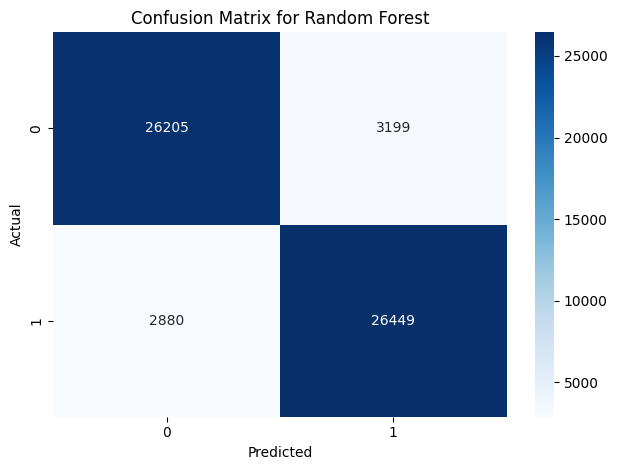

In [77]:
X_train, X_val, y_train, y_val = train_test_split(reduced_X,y,test_size=0.2,random_state=42)
rfc.fit(X_train,y_train)

plt.title("Confusion Matrix for Random Forest")
rfc_y_pred = rfc.predict(X_val)
cm = confusion_matrix(y_val, rfc_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1],yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

## K-Fold cross validation ROC curves for all the models

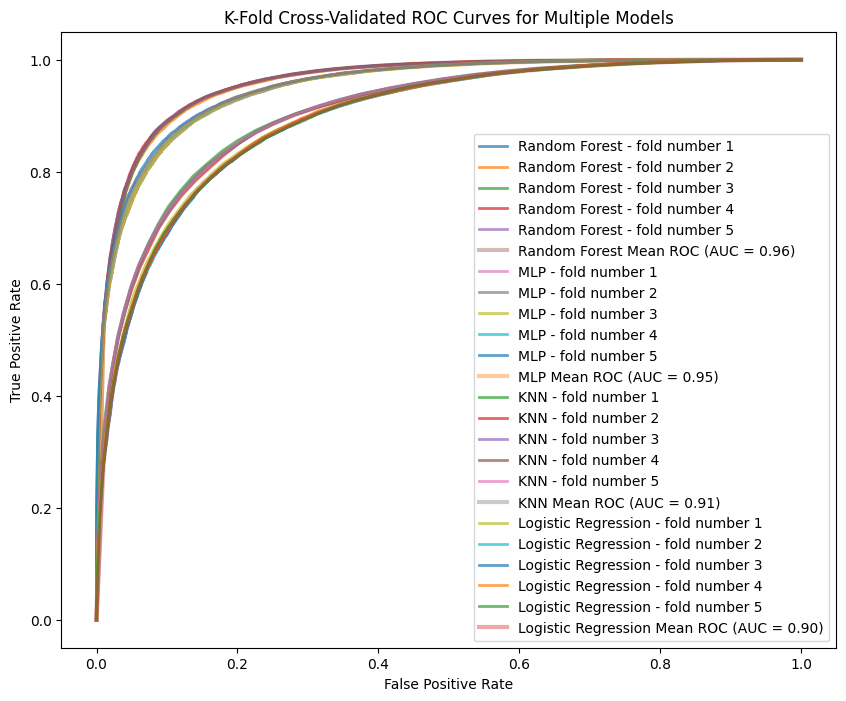

Random Forest:
  Train ROC AUC: 1.000 ± 0.000
  Val ROC AUC:   0.961 ± 0.001

MLP:
  Train ROC AUC: 0.955 ± 0.001
  Val ROC AUC:   0.951 ± 0.001

KNN:
  Train ROC AUC: 0.918 ± 0.000
  Val ROC AUC:   0.907 ± 0.001

Logistic Regression:
  Train ROC AUC: 0.897 ± 0.000
  Val ROC AUC:   0.897 ± 0.001



In [78]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))
results= {}
models = [("Random Forest" , rfc), ("MLP",mlpc), ("KNN", knc), ("Logistic Regression",lrc)]
for name, model in models:
    tprs = []
    train_aucs = []
    val_aucs = []
    
    for i, (train_index, val_index) in enumerate(kf.split(reduced_X, y)):
        X_train_fold, X_val_fold = reduced_X.iloc[train_index], reduced_X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
        
        # Fit the model on training fold
        model.fit(X_train_fold, y_train_fold)
        
        # Predict probabilities
        y_train_proba = model.predict_proba(X_train_fold)[:, 1]
        y_val_proba = model.predict_proba(X_val_fold)[:, 1]

        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_val_fold, y_val_proba)
        roc_auc = auc(fpr, tpr)
        val_aucs.append(roc_auc)
        
        # Compute train AUC
        train_auc = roc_auc_score(y_train_fold, y_train_proba)
        train_aucs.append(train_auc)
        
        # Interpolate TPR at mean FPR points for averaging
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)
        
        # Plot individual fold ROC curve with light color
        plt.plot(fpr, tpr, lw=2, alpha=0.7, label=f'{name} - fold number {i+1}')
    
    # Plot mean ROC curve for this model with bold line
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr, lw=3, alpha=0.4,
             label=f'{name} Mean ROC (AUC = {mean_auc:.2f})')

    results[name] = {
        'train_auc_mean': np.mean(train_aucs),
        'train_auc_std': np.std(train_aucs),
        'val_auc_mean': np.mean(val_aucs),
        'val_auc_std': np.std(val_aucs),
    }


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('K-Fold Cross-Validated ROC Curves for Multiple Models')
plt.legend(loc='lower right')
plt.show()

for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"  Train ROC AUC: {metrics['train_auc_mean']:.3f} ± {metrics['train_auc_std']:.3f}")
    print(f"  Val ROC AUC:   {metrics['val_auc_mean']:.3f} ± {metrics['val_auc_std']:.3f}")
    print()

## Accuracy Test for Dimensions reduction

This is how I checked which kind of dimensionality reduction I should use if any.<br>
This code took about an hour to run so I put it in a comment and is not supposed to be run in the project. <br>
The results of these calculations can be found in appendix 2.3 in the report.

In [79]:
"""X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(pca_X,y,test_size=0.2,random_state=42)
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(raw_X,y,test_size=0.2,random_state=42)
X_train_rfs, X_val_rfs, y_train_rfs, y_val_rfs = train_test_split(reduced_X,y,test_size=0.2,random_state=42)

results = {}
models = [("Random Forest" , rfc), ("MLP",mlpc), ("KNN", knc), ("Logistic Regression",lrc)]
for name, model in models:

    # Checking scores for the reduced data
    model.fit(X_train_rfs,y_train_rfs)
    y_preds = model.predict(X_val_rfs)
    y_train_preds = model.predict(X_train_rfs)
    rfs_val_accuracy = accuracy_score(y_val_rfs,y_preds)
    rfs_train_accuracy = accuracy_score(y_train_rfs,y_train_preds)

    # Checking scores for the pca data
    model.fit(X_train_pca,y_train_pca)
    y_preds = model.predict(X_val_pca)
    y_train_preds = model.predict(X_train_pca)
    pca_val_accuracy = accuracy_score(y_val_pca,y_preds)
    pca_train_accuracy = accuracy_score(y_train_pca,y_train_preds)
    
    # Checking scores for the raw data
    model.fit(X_train_raw, y_train_raw)
    y_preds = model.predict(X_val_raw)
    y_train_preds = model.predict(X_train_raw)
    raw_val_accuracy = accuracy_score(y_val_raw, y_preds)
    raw_train_accuracy = accuracy_score(y_train_raw,y_train_preds)

    results[name] = {
        "RF Selection: Train accuracy" : rfs_train_accuracy,
        "RF Selection: Val accuracy" : rfs_val_accuracy,
        "PCA: Train accuracy" : pca_train_accuracy,
        "PCA: Val accuracy": pca_val_accuracy,
        "RAW: Train accuracy" : raw_train_accuracy,
        "RAW: Val accuracy" : raw_val_accuracy
    }


for name, metrics in results.items():
    print(f"{name}:")
    print(f"RF Selection:\n  Train: {metrics['RF Selection: Train accuracy']:.3f}\n  Val: {metrics['RF Selection: Val accuracy']:.3f}\n  Difference = {(metrics['RF Selection: Train accuracy']-metrics['RF Selection: Val accuracy']):.3f}")
    print(f"PCA results:\n  Train: {metrics['PCA: Train accuracy']:.3f}\n  Val: {metrics['PCA: Val accuracy']:.3f}\n  Difference = {(metrics['PCA: Train accuracy']-metrics['PCA: Val accuracy']):.3f}")
    print(f"RAW results:\n  Train: {metrics['RAW: Train accuracy']:.3f}\n  Val: {metrics['RAW: Val accuracy']:.3f}\n  Difference = {(metrics['RAW: Train accuracy']-metrics['RAW: Val accuracy']):.3f}")
    print()
"""

'X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(pca_X,y,test_size=0.2,random_state=42)\nX_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(raw_X,y,test_size=0.2,random_state=42)\nX_train_rfs, X_val_rfs, y_train_rfs, y_val_rfs = train_test_split(reduced_X,y,test_size=0.2,random_state=42)\n\nresults = {}\nmodels = [("Random Forest" , rfc), ("MLP",mlpc), ("KNN", knc), ("Logistic Regression",lrc)]\nfor name, model in models:\n\n    # Checking scores for the reduced data\n    model.fit(X_train_rfs,y_train_rfs)\n    y_preds = model.predict(X_val_rfs)\n    y_train_preds = model.predict(X_train_rfs)\n    rfs_val_accuracy = accuracy_score(y_val_rfs,y_preds)\n    rfs_train_accuracy = accuracy_score(y_train_rfs,y_train_preds)\n\n    # Checking scores for the pca data\n    model.fit(X_train_pca,y_train_pca)\n    y_preds = model.predict(X_val_pca)\n    y_train_preds = model.predict(X_train_pca)\n    pca_val_accuracy = accuracy_score(y_val_pca,y_preds)\n    pca_trai

# Part 5: Model Predictions

## Only the prediction code

In [ ]:
rfc.fit(reduced_X,y)
y_pred_proba = rfc.predict_proba(reduced_test)[:, 1]
submission = pd.DataFrame({
    'ID': test_ids,
    'TARGET': y_pred_proba
})
submission.to_csv('results_50.csv', index=False)

## Full Project Pipeline

### Imports

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
from scipy import stats as st

# for preprocessing:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

# for modeling:
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_auc_score
from sklearn.metrics import RocCurveDisplay, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Methods

In [82]:
# ALL THE METHODS USED FOR PREPROCESSING
def fill_col1_and_col2(target_df, col1, col2, train_df=None, viceversa=False, unique_fill=False):
    """
    Fills missing values in two columns based on the mapping from a training DataFrame.
    If there are more than one unique value from col2 in col1 and the values are numerical, We use the median value of col2 for the filling.
    If there are more than one unique value from col2 in col1 and the values aren't numerical we use the first value found.
    If `viceversa` is True, it also fills missing values in the opposite direction, in the same method as mentioned above.
    If `unique_fill` is True, it fills the remaining missing values in the first column with its own most frequent value.
    If `unique_fill` is False, it fills the remaining missing values in the first column based on the most frequent value in the second column.
    """
    # Check if the training DataFrame is provided; if not, use the target DataFrame
    if train_df is None:
        train_df = target_df
    
    # Build mapping dictionaries from the training DataFrame
    col1_to_col2 = train_df.dropna(subset=[col1, col2]).groupby(col1)[col2].apply(lambda x: x.unique().tolist()).to_dict()
    try:
        col1_to_col2 = {k: np.median(v) for k, v in col1_to_col2.items()}
    except:
        try:
            col1_to_col2 = {k: v[0] for k, v in col1_to_col2.items()}
        except:
            col1_to_col2 = {k: v for k, v in col1_to_col2.items()}

    if viceversa:
        col2_to_col1 = train_df.dropna(subset=[col1, col2]).groupby(col2)[col1].apply(lambda x: x.unique().tolist()).to_dict()
        try:
            col2_to_col1 = {k: np.median(v) for k, v in col2_to_col1.items()}
        except:
            try:
                col2_to_col1 = {k: v[0] for k, v in col1_to_col2.items()}
            except:
                col2_to_col1 = {k: v for k, v in col1_to_col2.items()}

    
    # Fill missing values in the target DataFrame
    missing_col2 = target_df[col2].isnull() & target_df[col1].notnull()
    target_df.loc[missing_col2, col2] = target_df.loc[missing_col2, col1].map(col1_to_col2)
    if viceversa:
        missing_col1 = target_df[col1].isnull() & target_df[col2].notnull()
        target_df.loc[missing_col1, col1] = target_df.loc[missing_col1, col2].map(col2_to_col1)
    
    # Fill remaining missing values
    if viceversa:
        # If `unique_fill` is True, it fills the remaining missing values in each column with its own most frequent value.
        if unique_fill:
            most_freq_col2 = train_df[col2].mode()[0]
            target_df[col2].fillna(most_freq_col2, inplace=True)
            most_freq_col1 = train_df[col1].mode()[0]
            target_df[col1].fillna(most_freq_col1, inplace=True)
        # If `unique_fill` is False, it fills the remaining missing values in the second column based on the most frequent value in the first column.
        else:
            most_freq_col1 = train_df[col1].mode()[0]
            target_df[col1].fillna(most_freq_col1, inplace=True)
            target_df[col2].fillna(col1_to_col2[most_freq_col1], inplace=True)
    else:
        most_freq_col2 = train_df[col2].mode()[0]
        target_df[col2].fillna(most_freq_col2, inplace=True)
    
    return target_df

def fill_null_with_mode(target_df, cols, mode_col,train_df=None):
    """
    Fill Null values in columns with the mode of a specific column.
    """
    if train_df is None:
        train_df = target_df
        
    for col in cols:
        na_mask = target_df[col].isna()
        for idx in target_df[na_mask].index:
            value = target_df.loc[idx, mode_col]
            mode_value = train_df.loc[
                (train_df[mode_col] == value) & (~train_df[col].isna()), col
                ].mode()
            if not mode_value.empty:
                target_df.at[idx, col] = mode_value[0]
        # If there are still NaN values, fill them with the most common value in the column
        if target_df[col].isna().any():
            most_common_value = train_df[col].mode()[0]
            target_df[col].fillna(most_common_value, inplace=True)
    
    return target_df

def merge_values(df, cols):
    for col in cols:
        mask1 = df[col] == "Information not provided by applicant in mail, Internet, or telephone application"
        mask2 = df[col] == "Not applicable"
        df.loc[mask1,col] = "Not provided"
        df.loc[mask2,col] = "Not provided"
    return df

def remove_outliers(target_df, cols):
    for col in cols:
        q99 = target_df[col].quantile(0.99)
        target_df[col] = target_df[col].clip(upper=q99)
    return target_df

### Preprocessing - Training data

In [ ]:
# Drop uninformative columns
data = data.drop(['applicant_race_name_2','applicant_race_name_3','co_applicant_race_name_2','co_applicant_race_name_3'], axis=1)

# Fill columns A, B & D
A_mean_imputer = SimpleImputer(strategy='mean')
B_median_imputer = SimpleImputer(strategy='median')
cat_mode_imputer = SimpleImputer(strategy='most_frequent')
data['A'] = A_mean_imputer.fit_transform(data[['A']])
data['B'] = B_median_imputer.fit_transform(data[['B']])
data['D'] = cat_mode_imputer.fit_transform(data[['D']])

# Fill with fill_col1_and_col2
data = fill_col1_and_col2(data, 'county','county_code',viceversa=True, unique_fill=False)
data = fill_col1_and_col2(data, 'census_tract_number','population',viceversa=True, unique_fill=False)
data = fill_col1_and_col2(data, 'tract_to_msamd_income','msamd', viceversa=False)
data = fill_col1_and_col2(data, 'census_tract_number','minority_population', viceversa=False)

# Calculate the median for each loan purpose
refin_median = data[data['loan_purpose'] == "refinencing"]['loan_amount'].median()
home_pur_median = data[data['loan_purpose'] == "Home purchase"]['loan_amount'].median()
home_imp_median = data[data['loan_purpose'] == "Home improvement"]['loan_amount'].median()

# Fill missing values in 'loan_amount' based on 'loan_purpose'
data.loc[data['loan_purpose'] == "Home purchase", 'loan_amount'] = data[data['loan_purpose'] == "Home purchase"]['loan_amount'].fillna(home_pur_median)
data.loc[data['loan_purpose'] == "refinencing", 'loan_amount'] = data[data['loan_purpose'] == "refinencing"]['loan_amount'].fillna(refin_median)
data.loc[data['loan_purpose'] == "Home improvement", 'loan_amount'] = data[data['loan_purpose'] == "Home improvement"]['loan_amount'].fillna(home_imp_median)
data['loan_amount'] = data['loan_amount'].fillna(data['loan_amount'].median())

# Fill missing values using mode
data = fill_null_with_mode(data, ['loan_type', 'loan_purpose'],'loan_amount')
data = fill_null_with_mode(data, ['agency','property_type','hud_median_family_income','tract_to_msamd_income', 'number_of_owner_occupied_units'],'census_tract_number')
data = fill_null_with_mode(data, ["C"], "number_of_owner_occupied_units")

# Fill missing values in preapproval, owner_occupancy and lien_status with Not applicable
cat_cols = ['preapproval','owner_occupancy','lien_status']
data[cat_cols] = data[cat_cols].fillna('Not applicable')
# Fill missing applicant values with Not provided
applicant_cols = ['applicant_ethnicity','applicant_race_name_1','applicant_sex']
data[applicant_cols] = data[applicant_cols].fillna('Not provided')

# Fill missing co applicant values
nca_str = "No co-applicant"
mask = ((data['co_applicant_ethnicity'] == nca_str) | (data['co_applicant_race_name_1'] == nca_str) | (data['co_applicant_sex'] == nca_str))
for col in ['co_applicant_ethnicity','co_applicant_race_name_1','co_applicant_sex']:
    data.loc[mask, col] = data.loc[mask, col].fillna('No co-applicant')
data['co_applicant_ethnicity'] = data['co_applicant_ethnicity'].fillna(data['applicant_ethnicity'])
data['co_applicant_race_name_1'] = data['co_applicant_race_name_1'].fillna(data['applicant_race_name_1'])
data[data['applicant_sex']=='Male']["co_applicant_sex"] = data[data['applicant_sex']=='Male']["co_applicant_sex"].fillna('Female')
data[data['applicant_sex']=='Female']["co_applicant_sex"] = data[data['applicant_sex']=='Female']["co_applicant_sex"].fillna('Male')
data["co_applicant_sex"] = data["co_applicant_sex"].fillna('Not provided')

# Fill applicant Income
median_income_by_ethnicity = data.groupby("applicant_ethnicity")["applicant_income"].median()
median_income_by_sex = data.groupby("applicant_sex")["applicant_income"].median()
na_mask = data['applicant_income'].isna()
for idx in data[na_mask].index:
    sex = data.loc[idx, 'applicant_sex']
    ethnicity = data.loc[idx, 'applicant_ethnicity']
    data.at[idx, 'applicant_income'] = (median_income_by_sex[sex] + median_income_by_ethnicity[ethnicity]) / 2

# Merge values
cat_feat_to_fix = ["applicant_ethnicity","applicant_race_name_1","co_applicant_ethnicity","co_applicant_race_name_1","applicant_sex","co_applicant_sex"]
data = merge_values(data,cat_feat_to_fix)

full_data = data.copy()

# Deleting outliers from train data
data = remove_outliers(data, ['loan_amount', 'applicant_income', 'tract_to_msamd_income'])


# calculate the approval rate for each county
county_approval_rate = data.groupby('county')['label'].mean()
data['county_approval_rate'] = data['county'].map(county_approval_rate)
# calculate the approval rate for each msamd
msamd_approval_rate = data.groupby('msamd')['label'].mean()
data['msamd_approval_rate'] = data['msamd'].map(msamd_approval_rate)
# calculate the approval rate for each census tract
census_tract_approval_rate = data.groupby('census_tract_number')['label'].mean()
data['census_tract_approval_rate'] = data['census_tract_number'].map(census_tract_approval_rate)

#--- the resaults here will be used to map the approval rates in the test set as well

# Drop unnecessary columns
data = data.drop(["county",'county_code','msamd','census_tract_number'],axis=1)

# Encode categorical cols
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
enc = OrdinalEncoder()
cat_for_OE = categorical_cols[data[categorical_cols].nunique()>3]
cat_for_dummy = categorical_cols[data[categorical_cols].nunique()<=3]

data[cat_for_OE] = enc.fit_transform(data[cat_for_OE])
dummies = pd.get_dummies(data[cat_for_dummy], prefix=cat_for_dummy, drop_first=True)
data = pd.concat([data.drop(columns=cat_for_dummy), dummies], axis=1)

# Split features and label
full_X = data.drop('label', axis=1)
y = data['label']

stand_scaler = StandardScaler()
scaled_data = stand_scaler.fit_transform(full_X)
full_X = pd.DataFrame(scaled_data, columns=full_X.columns)

# Dimension reduction using feature importance from Random Forest model
X_train, X_val, y_train, y_val = train_test_split(full_X,y,test_size=0.2,random_state=42)
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
importances = pd.Series(model.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False)
cumulative = importances.cumsum()
k = np.argmax(cumulative >= 0.95) + 1  # +1 because indices are 0-based
top_features = importances.index[:k]
X_train_new = X_train[top_features]
X_val_new = X_val[top_features]
reduced_X = full_X[top_features]


### Preprocessing - Test data

In [ ]:
test_ids = test['ID']

# Drop uninformative columns
test = test.drop(['applicant_race_name_2','applicant_race_name_3','co_applicant_race_name_2','co_applicant_race_name_3'], axis=1)

# Fill columns A, B & D
test['A'] = A_mean_imputer.transform(test[['A']])
test['B'] = B_median_imputer.transform(test[['B']])
test['D'] = cat_mode_imputer.transform(test[['D']])

# Fill with fill_col1_and_col2
test = fill_col1_and_col2(test,'county', 'county_code', train_df=full_data, viceversa=True, unique_fill=False)
test = fill_col1_and_col2(test, 'census_tract_number','population', train_df=full_data, viceversa=True)
test = fill_col1_and_col2(test, 'tract_to_msamd_income','msamd', train_df=full_data, viceversa=False)
test = fill_col1_and_col2(test, 'census_tract_number','minority_population',train_df=full_data, viceversa=False)

# Fill missing values in 'loan_amount' based on 'loan_purpose'
test.loc[test['loan_purpose'] == "Home purchase", 'loan_amount'] = test[test['loan_purpose'] == "Home purchase"]['loan_amount'].fillna(home_pur_median)
test.loc[test['loan_purpose'] == "refinencing", 'loan_amount'] = test[test['loan_purpose'] == "refinencing"]['loan_amount'].fillna(refin_median)
test.loc[test['loan_purpose'] == "Home improvement", 'loan_amount'] = test[test['loan_purpose'] == "Home improvement"]['loan_amount'].fillna(home_imp_median)
test['loan_amount'] = test['loan_amount'].fillna(general_loan_amount_median)

# Fill missing values using mode
test = fill_null_with_mode(test, ['loan_type', 'loan_purpose'],'loan_amount',train_df = full_data)
test = fill_null_with_mode(test,['C'], 'number_of_owner_occupied_units',train_df = full_data)
test = fill_null_with_mode(test, ['agency','property_type','hud_median_family_income','tract_to_msamd_income', 'number_of_owner_occupied_units'],'census_tract_number',train_df = full_data)

# Fill missing values in preapproval, owner_occupancy and lien_status with Not applicable
cat_cols = ['preapproval','owner_occupancy','lien_status']
test[cat_cols] = test[cat_cols].fillna('Not applicable')
# Fill missing applicant values with Not provided
applicant_cols = ['applicant_ethnicity','applicant_race_name_1','applicant_sex']
test[applicant_cols] = test[applicant_cols].fillna('Not provided')

# Fill missing co applicant values
nca_str = "No co-applicant"
mask = ((test['co_applicant_ethnicity'] == nca_str) | (test['co_applicant_race_name_1'] == nca_str) | (test['co_applicant_sex'] == nca_str))
for col in ['co_applicant_ethnicity','co_applicant_race_name_1','co_applicant_sex']:
    test.loc[mask, col] = test.loc[mask, col].fillna('No co-applicant')
test['co_applicant_ethnicity'] = test['co_applicant_ethnicity'].fillna(test['applicant_ethnicity'])
test['co_applicant_race_name_1'] = test['co_applicant_race_name_1'].fillna(test['applicant_race_name_1'])
test[test['applicant_sex']=='Male']["co_applicant_sex"] = test[test['applicant_sex']=='Male']["co_applicant_sex"].fillna('Female')
test[test['applicant_sex']=='Female']["co_applicant_sex"] = test[test['applicant_sex']=='Female']["co_applicant_sex"].fillna('Male')
test["co_applicant_sex"] = test["co_applicant_sex"].fillna('Not provided')

# Fill applicant Income
na_mask = test['applicant_income'].isna()
for idx in test[na_mask].index:
    sex = test.loc[idx, 'applicant_sex']
    ethnicity = test.loc[idx, 'applicant_ethnicity']
    test.at[idx, 'applicant_income'] = (median_income_by_sex[sex] + median_income_by_ethnicity[ethnicity]) / 2

# Merge similar and unknown values in the categorical features
test = merge_values(test, cat_feat_to_fix)

# insert the new columns with the approval rates from the training set
test['county_approval_rate'] = test['county'].map(county_approval_rate)
test['msamd_approval_rate'] = test['msamd'].map(msamd_approval_rate)
test['census_tract_approval_rate'] = test['census_tract_number'].map(census_tract_approval_rate)

# Fill missing values in the census_tract_approval_rate
if(test['census_tract_approval_rate'].isna().any()):
    for idx in test[test['census_tract_approval_rate'].isna()].index:
        census_tract_number = test.loc[idx, 'census_tract_number']
        mean_approval_rate = census_tract_approval_rate[round(census_tract_number,0):census_tract_number+1].mean()
        if not pd.isna(mean_approval_rate):
            test.at[idx, 'census_tract_approval_rate'] = mean_approval_rate
        else:
            test.at[idx, 'census_tract_approval_rate'] = 0.5

# Drop unnecessary columns
test = test.drop(["county",'county_code','msamd','census_tract_number'],axis=1)

# encode categorical features
test[cat_for_OE] = enc.transform(test[cat_for_OE])
dummies = pd.get_dummies(test[cat_for_dummy], prefix=cat_for_dummy, drop_first=True)
test = pd.concat([test.drop(columns=cat_for_dummy), dummies], axis=1)

# Align test columns to match the scaler's training columns
stand_test = stand_scaler.transform(test)
test = pd.DataFrame(stand_test, columns=test.columns)

# Reduce to the dimensions of the train data
reduced_test = test[top_features]

### Modeling

In [85]:
rfc = RandomForestClassifier(max_depth=31, n_estimators=291,max_features=0.5, random_state=42, n_jobs=-1)
rfc.fit(reduced_X,y)

RandomForestClassifier(max_depth=31, max_features=0.5, n_estimators=291,
                       n_jobs=-1, random_state=42)

### Predictions

In [86]:
y_pred_proba = rfc.predict_proba(reduced_test)[:, 1]
submission = pd.DataFrame({
    'ID': test_ids,
    'TARGET': y_pred_proba
})

### Export

In [ ]:
submission.to_csv('results_50.csv', index=False)

<center>
<font size=6>The End</font>
</center>